# Speaker Encoder (GE2E)

In [1]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0))
print("CUDA version:", torch.version.cuda)

PyTorch version: 2.7.1+cu128
CUDA available: True
Device name: NVIDIA GeForce RTX 5070
CUDA version: 12.8


In [2]:
import torch
print(torch.__version__) 
print(torch.version.cuda)
print(torch.cuda.get_device_name(0))


2.7.1+cu128
12.8
NVIDIA GeForce RTX 5070


In [1]:
import os
import math
import random
from pathlib import Path
from typing import List, Dict, Tuple

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [3]:
PROCESSED_DIR = Path("C:/Users/ADMIN/Downloads/SSP/VoiceProject/processed")  # <-- change to your absolute path if you prefer
MEL_NORM_DIR = PROCESSED_DIR / "normalized"
FEATURE_DIR = PROCESSED_DIR / "features"   # fallback if normalized not found

TRAIN_META = PROCESSED_DIR / "train_metadata.csv"
TEST_META  = PROCESSED_DIR / "test_metadata.csv"

assert TRAIN_META.exists(), f"Missing file: {TRAIN_META}"
assert MEL_NORM_DIR.exists() or FEATURE_DIR.exists(), "No features folder found."

print("Using device:", DEVICE)
print("Processed dir :", PROCESSED_DIR.resolve())
print("Mels (norm)  :", MEL_NORM_DIR.resolve())

Using device: cuda
Processed dir : C:\Users\ADMIN\Downloads\SSP\VoiceProject\processed
Mels (norm)  : C:\Users\ADMIN\Downloads\SSP\VoiceProject\processed\normalized


## Load Metadata & Build Speaker→Utterances map

In [4]:
train_df = pd.read_csv(TRAIN_META)

# from preProcessing notebook
required_cols = {"utt_id", "speaker"}
missing = required_cols - set(train_df.columns)
assert not missing, f"Missing columns in train_metadata.csv: {missing}"

# Build mapping: speaker -> list of mel paths
def find_mel_path(utt_id: str) -> Path:
    # normalized first
    p = MEL_NORM_DIR / f"{utt_id}_mel.npy"
    if p.exists():
        return p
    # fallback to unnormalized features
    p2 = FEATURE_DIR / f"{utt_id}_mel.npy"
    if p2.exists():
        return p2
    return None

spk2utts: Dict[str, List[Path]] = {}
skipped = 0
for _, r in train_df.iterrows():
    utt_id = str(r["utt_id"])
    spk = str(r["speaker"])
    melp = find_mel_path(utt_id)
    if melp is None:
        skipped += 1
        continue
    spk2utts.setdefault(spk, []).append(melp)

num_spk = len(spk2utts)
num_utts = sum(len(v) for v in spk2utts.values())

print(f"Speakers in train: {num_spk}")
print(f"Total utterances  : {num_utts}")
print(f"Missing mel files : {skipped}")
# Also show a few counts
{spk: len(v) for spk, v in list(spk2utts.items())[:5]}


Speakers in train: 222
Total utterances  : 29102
Missing mel files : 0


{'103': 66, '1034': 30, '1040': 134, '1069': 112, '1081': 8}

## Hyperparameters

In [5]:
N_SPK = 32          # speakers per batch 
M_UTT = 8           # utterances per speaker
SEGMENT_FRAMES = 160  # frames per segment 
MEL_DIM = 80
EMBED_DIM = 256

LR = 1e-3
EPOCHS = 6
STEPS_PER_EPOCH = 800
GRAD_CLIP = 3.0

BATCH_NUM_WORKERS = 4   # DataLoader workers
PIN_MEMORY = True

USE_AMP = True  # mixed precision

CHECKPOINT_DIR = Path("checkpoints/encoder")
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

print("Hyperparams set. Using AMP:", USE_AMP)


Hyperparams set. Using AMP: True


## Utilities: load mel, crop/pad

In [6]:
def load_mel(mel_path: Path) -> np.ndarray:
    mel = np.load(mel_path)
    if mel.ndim != 2 or mel.shape[1] != MEL_DIM:
        raise ValueError(f"Unexpected mel shape {mel.shape} for {mel_path}")
    return mel.astype(np.float32)

def crop_or_pad(mel: np.ndarray, segment_frames: int) -> np.ndarray:
    T = mel.shape[0]
    if T == segment_frames:
        return mel
    if T > segment_frames:
        start = np.random.randint(0, T - segment_frames + 1)
        return mel[start:start+segment_frames]
    # pad
    pad = np.zeros((segment_frames - T, mel.shape[1]), dtype=mel.dtype)
    return np.concatenate([mel, pad], axis=0)


In [7]:
# Build mapping from speaker → utterance paths
MEL_DIR = Path("C:/Users/ADMIN/Downloads/SSP/VoiceProject/processed/features")

spk2utts = {}
for mel_file in MEL_DIR.glob("*.npy"):
    # assume filenames like spk1_utt1.npy
    spk = mel_file.stem.split("_")[0]
    spk2utts.setdefault(spk, []).append(mel_file)


Total speakers: 248
Utterances per speaker: min = 2 max = 1374 avg = 402.05645161290323


In [9]:
# Inspect one entry
first_spk = next(iter(spk2utts))
print("Example speaker:", first_spk)
print("Utterances:", spk2utts[first_spk][:5])


Example speaker: 1034
Utterances: [WindowsPath('C:/Users/ADMIN/Downloads/SSP/VoiceProject/processed/features/1034_121119_000001_000001_energy.npy'), WindowsPath('C:/Users/ADMIN/Downloads/SSP/VoiceProject/processed/features/1034_121119_000001_000001_mel.npy'), WindowsPath('C:/Users/ADMIN/Downloads/SSP/VoiceProject/processed/features/1034_121119_000001_000001_pitch.npy'), WindowsPath('C:/Users/ADMIN/Downloads/SSP/VoiceProject/processed/features/1034_121119_000002_000001_energy.npy'), WindowsPath('C:/Users/ADMIN/Downloads/SSP/VoiceProject/processed/features/1034_121119_000002_000001_mel.npy')]


## Sampler & Dataset

In [10]:
import random

class GE2ESampler:
    def __init__(self, spk2utts, N, M):
        """
        spk2utts: dict {speaker_id: [list of mel.npy paths]}
        N: number of speakers per batch
        M: number of utterances per speaker
        """
        # Filter speakers with at least M valid utterances
        self.spk2utts = {
            spk: [u for u in utts if str(u).endswith("_mel.npy")]
            for spk, utts in spk2utts.items()
            if len([u for u in utts if str(u).endswith("_mel.npy")]) >= M
        }
        self.speakers = list(self.spk2utts.keys())
        self.N = N
        self.M = M

        if len(self.speakers) < N:
            raise ValueError(f"Not enough speakers with >= {M} utterances. "
                             f"Available: {len(self.speakers)}, required: {N}")

        print(f"[GE2ESampler] Initialized with {len(self.speakers)} speakers")

    def sample_batch(self):
        """Returns [(spk, [utt1,...,uttM]), ...]"""
        speakers = random.sample(self.speakers, self.N)  # pick N speakers
        batch = []

        for spk in speakers:
            available_utts = self.spk2utts[spk]
            #print(f"[GE2ESampler] Sampling for speaker: {spk}, "
                  #f"available: {len(available_utts)}, requested: {self.M}")
            utts = random.sample(available_utts, self.M)  # pick M utterances
            batch.append((spk, utts))

        return batch


In [11]:
class GE2EDataset(Dataset):
    def __init__(self, sampler, segment_frames):
        self.sampler = sampler
        self.segment_frames = segment_frames

    def __getitem__(self, idx):
        batch = self.sampler.sample_batch()  # [(spk, [utt1, utt2,...]), ...]
        specs = []
        for spk, utts in batch:
            spk_specs = []
            for feat_path in utts:
                # load mel feature
                spec = np.load(feat_path)  # [T, F]

                # cut or pad to fixed length
                T = spec.shape[0]
                if T >= self.segment_frames:
                    start = np.random.randint(0, T - self.segment_frames + 1)
                    seg = spec[start:start + self.segment_frames]
                else:
                    seg = np.pad(spec, ((0, self.segment_frames - T), (0, 0)))
                spk_specs.append(seg)

            specs.append(spk_specs)

        return torch.tensor(np.array(specs), dtype=torch.float32) # [N, M, T, F]

    def __len__(self):
        return 10**9  # virtually infinite

In [11]:
class GE2EDataset(Dataset):
    def __init__(self, sampler, segment_frames, num_batches=1000):
        self.sampler = sampler
        self.segment_frames = segment_frames
        self.num_batches = num_batches  # Finite number of batches

    def __getitem__(self, idx):
        batch = self.sampler.sample_batch()
        specs = []
        for spk, utts in batch:
            spk_specs = []
            for feat_path in utts:
                spec = np.load(feat_path)
                T = spec.shape[0]
                if T >= self.segment_frames:
                    start = np.random.randint(0, T - self.segment_frames + 1)
                    seg = spec[start:start + self.segment_frames]
                else:
                    seg = np.pad(spec, ((0, self.segment_frames - T), (0, 0)))
                spk_specs.append(seg)
            specs.append(spk_specs)
        return torch.tensor(np.array(specs), dtype=torch.float32)

    def __len__(self):
        return self.num_batches  # Finite length

## Create dataloader

In [12]:

N_SPK = 4        # number of speakers per batch
M_UTT = 5        # number of utterances per speaker
SEGMENT_FRAMES = 160   # frames per segment
PIN_MEMORY = True

sampler = GE2ESampler(spk2utts, N_SPK, M_UTT)
dataset = GE2EDataset(sampler, SEGMENT_FRAMES)

loader = DataLoader(dataset, batch_size=1, shuffle=False,
                    num_workers=0, pin_memory=PIN_MEMORY)

# Sanity check
batch = next(iter(loader))  # [1, N, M, T, F]
print("raw loader batch shape:", tuple(batch.shape))

[GE2ESampler] Initialized with 242 speakers
raw loader batch shape: (1, 4, 5, 160, 80)


## SpeakerEncoder model

#### conv blocks + GRU + projection

In [13]:

class SpeakerEncoder(nn.Module):
    def __init__(self, mel_dim=80, embed_dim=256):
        super().__init__()
        # conv stack
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(5,5), padding=(2,2)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=(5,5), padding=(2,2)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=(3,3), padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        # GRU
        # after conv: [B, C, T, F] -> we'll permute to [B, T, C*F]
        self.gru = nn.GRU(input_size=256 * mel_dim, hidden_size=768, batch_first=True)
        self.proj = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Linear(512, embed_dim)
        )

    def forward(self, x):
        # x: [B, T, F] or [B, 1, T, F]
        if x.dim() == 3:
            x = x.unsqueeze(1)
        h = self.conv(x)                       # [B, C, T, F]
        B, C, T, Fm = h.shape
        h = h.permute(0, 2, 1, 3).contiguous().view(B, T, C * Fm)  # [B, T, C*F]
        _, hn = self.gru(h)                    # hn: [1, B, hid]
        hn = hn.squeeze(0)                     # [B, hid]
        e = self.proj(hn)                      # [B, embed_dim]
        e = F.normalize(e, p=2, dim=1)         # L2 norm
        return e


## Vectorized GE2E loss (efficient)

In [14]:
class GE2ELoss(nn.Module):
    def __init__(self, init_w=10.0, init_b=-5.0):
        super().__init__()
        self.w = nn.Parameter(torch.tensor(init_w, dtype=torch.float32))
        self.b = nn.Parameter(torch.tensor(init_b, dtype=torch.float32))

    def forward(self, embeddings: torch.Tensor):
        """
        embeddings: [N, M, D]
        returns scalar loss
        """
        N, M, D = embeddings.shape
        device = embeddings.device

        # centroids (per speaker)
        centroids = embeddings.mean(dim=1)          # [N, D]

        # exclusion centroids: (sum - emb) / (M-1)
        sum_spk = embeddings.sum(dim=1, keepdim=True)    # [N,1,D]
        excl = (sum_spk - embeddings) / (M - 1)          # [N,M,D]

        # Flattened representations
        E = embeddings.view(N*M, D)              # [NM, D]
        E_norm = F.normalize(E, dim=1)           # [NM, D]
        cent_norm = F.normalize(centroids, dim=1) # [N, D]
        excl_flat = excl.view(N*M, D)
        excl_norm = F.normalize(excl_flat, dim=1) # [NM, D]

        # similarity matrix between each utterance and all centroids
        S = torch.matmul(E_norm, cent_norm.t())   # [NM, N]

        # compute own-speaker similarity using exclusion centroids
        targets = torch.arange(N, device=device).unsqueeze(1).repeat(1, M).view(-1)  # [NM]
        rows = torch.arange(N*M, device=device)
        own_sims = torch.sum(E_norm * excl_norm, dim=1)  # [NM]
        own_sims = own_sims.to(S.dtype) 
        S[rows, targets] = own_sims

        # scale & bias
        S = self.w * S + self.b

        loss = F.cross_entropy(S, targets)
        return loss


In [15]:
from torch.cuda.amp import GradScaler
from torch import amp

encoder = SpeakerEncoder(mel_dim=MEL_DIM, embed_dim=EMBED_DIM).to(DEVICE)
criterion = GE2ELoss().to(DEVICE)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(criterion.parameters()), lr=LR)
scaler = amp.GradScaler(enabled=USE_AMP)

print("Encoder params (M):", sum(p.numel() for p in encoder.parameters()) / 1e6)

Encoder params (M): 49.987712


In [16]:
def ge2e_train_step(batch_tensor: torch.Tensor):
    """
    batch_tensor: [1, N, M, T, F]
    returns loss (float)
    """
    encoder.train()
    criterion.train()
    optimizer.zero_grad()

    x = batch_tensor.squeeze(0).to(DEVICE)   # [N, M, T, F]
    N, M, T, F = x.shape
    x = x.view(N * M, T, F)                  # [NM, T, F]

    with torch.amp.autocast("cuda", enabled=USE_AMP):
        emb = encoder(x)                     # [NM, D]
        emb = emb.view(N, M, -1)             # [N, M, D]
        loss = criterion(emb)

    scaler.scale(loss).backward()
    # gradient clipping/unscale
    scaler.unscale_(optimizer)
    torch.nn.utils.clip_grad_norm_(encoder.parameters(), GRAD_CLIP)
    torch.nn.utils.clip_grad_norm_(criterion.parameters(), GRAD_CLIP)
    scaler.step(optimizer)
    scaler.update()

    return float(loss.detach().cpu().item())


In [19]:
!pip install tqdm

##### train LOOP

In [19]:
def train_loop(loader, epochs, steps_per_epoch):
    global_step = 0
    for ep in range(1, epochs + 1):
        t0 = perf_counter()
        losses = []
        it = iter(loader)
        for step in range(1, steps_per_epoch + 1):
            batch = next(it)  # [1, N, M, T, F]
            loss = ge2e_train_step(batch)
            losses.append(loss)
            global_step += 1

            #if step % 50 == 0:
               # print(f"Epoch {ep}/{epochs} Step {step}/{steps_per_epoch} AvgLoss {np.mean(losses[-50:]):.4f}")

        dt = perf_counter() - t0
        print(f"Epoch {ep} finished in {dt:.1f}s | AvgLoss {np.mean(losses):.4f}")

        ckpt = {
            "epoch": ep,
            "encoder_state": encoder.state_dict(),
            "criterion_state": criterion.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "scaler_state": scaler.state_dict(),
            "config": {"N_SPK": N_SPK, "M_UTT": M_UTT, "SEGMENT_FRAMES": SEGMENT_FRAMES}
        }
        ckpt_path = CHECKPOINT_DIR / f"encoder_ep{ep:03d}.pt"
        torch.save(ckpt, ckpt_path)
        print("Saved checkpoint:", ckpt_path.resolve())

In [20]:
from tqdm import trange
from time import perf_counter

def train_loop(loader, epochs, steps_per_epoch):
    global_step = 0
    for ep in range(1, epochs + 1):
        t0 = perf_counter()
        losses = []
        it = iter(loader)

        # tqdm progress bar for the current epoch
        for step in trange(1, steps_per_epoch + 1, desc=f"Epoch {ep}/{epochs}", ncols=100):
            batch = next(it)  # [1, N, M, T, F]
            loss = ge2e_train_step(batch)
            losses.append(loss)
            global_step += 1

        dt = perf_counter() - t0
        print(f"\n[Epoch {ep}/{epochs}] Time: {dt:.1f}s | AvgLoss: {np.mean(losses):.4f}")

        # Save checkpoint
        ckpt = {
            "epoch": ep,
            "encoder_state": encoder.state_dict(),
            "criterion_state": criterion.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "scaler_state": scaler.state_dict(),
            "config": {"N_SPK": N_SPK, "M_UTT": M_UTT, "SEGMENT_FRAMES": SEGMENT_FRAMES}
        }
        ckpt_path = CHECKPOINT_DIR / f"encoder_ep{ep:03d}.pt"
        torch.save(ckpt, ckpt_path)
        print("Saved checkpoint:", ckpt_path.resolve())


##### Early Stopping

In [17]:
def ge2e_validation_loss(model, val_loader):
    model.eval()
    losses = []

    with torch.no_grad():
        for batch in val_loader:
            x = batch.squeeze(0).to(DEVICE)  # [N, M, T, F]
            N, M, T, F = x.shape
            x = x.view(N * M, T, F)

            with torch.amp.autocast("cuda", enabled=USE_AMP):
                emb = model(x)
                emb = emb.view(N, M, -1)
                loss = criterion(emb)

            losses.append(loss.item())

    model.train()
    return np.mean(losses)


In [26]:
def train_loop(loader, val_loader, epochs, steps_per_epoch, patience=5, log_every=50):
    global_step = 0
    best_val_loss = float("inf")
    patience_counter = 0

    for ep in range(1, epochs + 1):
        t0 = perf_counter()
        losses = []
        it = iter(loader)

        # Training loop
        for step in trange(1, steps_per_epoch + 1, desc=f"Epoch {ep}/{epochs}", ncols=100, leave=False):
            try:
                batch = next(it)  # [1, N, M, T, F]
            except StopIteration:
                # Reset iterator if dataset exhausted
                it = iter(loader)
                batch = next(it)

            loss = ge2e_train_step(batch)
            losses.append(loss)
            global_step += 1

            if step % log_every == 0:
                print(f"[Epoch {ep} | Step {step}/{steps_per_epoch}] Loss: {loss:.4f}")

            # Optional: early stop mid-epoch
            if patience_counter >= patience:
                print(">>> Early stopping triggered mid-epoch.")
                return

        # End of epoch summary
        dt = perf_counter() - t0
        avg_loss = np.mean(losses)
        print(f"\n[Epoch {ep}/{epochs}] Time: {dt:.1f}s | AvgTrainLoss: {avg_loss:.4f}")

        # Validation
        val_loss = ge2e_validation_loss(encoder, val_loader)
        print(f"[Validation] ValLoss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0

            # Save checkpoint
            ckpt = {
                "epoch": ep,
                "encoder_state": encoder.state_dict(),
                "criterion_state": criterion.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "scaler_state": scaler.state_dict(),
                "config": {
                    "N_SPK": N_SPK,
                    "M_UTT": M_UTT,
                    "SEGMENT_FRAMES": SEGMENT_FRAMES
                }
            }
            best_path = CHECKPOINT_DIR / "best_model.pt"
            torch.save(ckpt, best_path)
            print(f"✔ Saved best model: {best_path.resolve()}")

        else:
            patience_counter += 1
            print(f"Patience counter: {patience_counter}/{patience}")

            if patience_counter >= patience:
                print(">>> Early stopping triggered after validation.")
                return

    print(">>> Training loop complete.")


###### using sklearn for splitting(didn't work)

In [34]:
!pip install --force-reinstall scikit-learn

   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.7 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.7 MB 1.6 MB/s eta 0:00:06
   --- ------------------------------------ 0.8/8.7 MB 1.7 MB/s eta 0:00:05
   ---- ----------------------------------- 1.0/8.7 MB 1.6 MB/s eta 0:00:05
   ------ --------------------------------- 1.3/8.7 MB 1.5 MB/s eta 0:00:05
   -------- ------------------------------- 1.8/8.7 MB 1.5 MB/s eta 0:00:05
   --------- ------------------------------ 2.1/8.7 MB 1.5 MB/s eta 0:00:05
   ---------- ----------------------------- 2.4/8.7 MB 1.5 MB/s eta 0:00:05
   ------------ --------------------------- 2.6/8.7 MB 1.5 MB/s eta 0:00:05
   ------------- -------------------------- 2.9/8.7 MB 1.5 MB/s eta 0:00:04
   -------------- ------------------------- 3.1/8.7 MB 1.4 MB/s eta 0:00:05
   -------------- ------------------------- 3.1/8.7 MB 1.4 MB/s eta 0:00:05
   --------------- -------

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.61.2 requires numpy<2.3,>=1.24, but you have numpy 2.3.2 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.1 which is incompatible.
streamlit 1.45.1 requires packaging<25,>=20, but you have packaging 25.0 which is incompatible.


In [35]:
from sklearn.model_selection import train_test_split

# Split speakers
spk_list = list(spk2utts.keys())
train_spks, val_spks = train_test_split(spk_list, test_size=0.2, random_state=42)

# Split dictionaries
spk2utts_train = {spk: spk2utts[spk] for spk in train_spks}
spk2utts_val = {spk: spk2utts[spk] for spk in val_spks}


ModuleNotFoundError: No module named 'sklearn'

###### Using torch.utils for splitting

In [27]:
import torch
from torch.utils.data import random_split

# Convert dict keys to list
spk_list = list(spk2utts.keys())

#Convert to a torch Dataset-like object (just a list is fine here)
total_spks = len(spk_list)
train_size = int(0.8 * total_spks)
val_size = total_spks - train_size

#Set manual seed for reproducibility (like random_state=42)
generator = torch.Generator().manual_seed(42)

#Use random_split
train_subset, val_subset = random_split(spk_list, [train_size, val_size], generator=generator)

#Convert back to dictionaries
spk2utts_train = {spk: spk2utts[spk] for spk in train_subset}
spk2utts_val = {spk: spk2utts[spk] for spk in val_subset}


In [28]:
NUM_TRAIN_BATCHES = 500  # Match steps_per_epoch
NUM_VAL_BATCHES = 100
# Train loader
train_sampler = GE2ESampler(spk2utts_train, N_SPK, M_UTT)
train_dataset = GE2EDataset(train_sampler, SEGMENT_FRAMES, num_batches=NUM_TRAIN_BATCHES)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
# Validation loader
val_sampler = GE2ESampler(spk2utts_val, N_SPK, M_UTT)
val_dataset = GE2EDataset(val_sampler, SEGMENT_FRAMES, num_batches=NUM_VAL_BATCHES)
val_loader =DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)


#train_dataset = GE2EDataset(train_sampler, SEGMENT_FRAMES)
#train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=PIN_MEMORY)
#val_dataset = GE2EDataset(val_sampler, SEGMENT_FRAMES)
#val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=PIN_MEMORY)

[GE2ESampler] Initialized with 194 speakers
[GE2ESampler] Initialized with 48 speakers


In [30]:
from time import perf_counter
from tqdm import tqdm
from tqdm import trange
from torch.cuda.amp import autocast
train_loop(
    loader=train_loader,
    val_loader=val_loader,
    epochs=100,
    steps_per_epoch=2000,   
    patience=15,
    log_every=100
)


Epoch 1/100:   5%|██▍                                            | 102/2000 [00:06<01:57, 16.14it/s]

[Epoch 1 | Step 100/2000] Loss: 1.5396


Epoch 1/100:  10%|████▋                                          | 202/2000 [00:12<01:49, 16.38it/s]

[Epoch 1 | Step 200/2000] Loss: 1.3867


Epoch 1/100:  15%|███████                                        | 302/2000 [00:19<01:47, 15.76it/s]

[Epoch 1 | Step 300/2000] Loss: 1.3867


Epoch 1/100:  20%|█████████▍                                     | 402/2000 [00:25<02:14, 11.88it/s]

[Epoch 1 | Step 400/2000] Loss: 1.3867


Epoch 1/100:  25%|███████████▊                                   | 502/2000 [00:32<01:30, 16.56it/s]

[Epoch 1 | Step 500/2000] Loss: 1.3870


Epoch 1/100:  30%|██████████████▏                                | 602/2000 [00:38<01:26, 16.24it/s]

[Epoch 1 | Step 600/2000] Loss: 1.3869


Epoch 1/100:  35%|████████████████▍                              | 702/2000 [00:44<01:17, 16.76it/s]

[Epoch 1 | Step 700/2000] Loss: 1.3286


Epoch 1/100:  40%|██████████████████▊                            | 802/2000 [00:50<01:11, 16.84it/s]

[Epoch 1 | Step 800/2000] Loss: 1.3867


Epoch 1/100:  45%|█████████████████████▏                         | 900/2000 [00:57<01:44, 10.56it/s]

[Epoch 1 | Step 900/2000] Loss: 1.3867


Epoch 1/100:  50%|███████████████████████                       | 1001/2000 [01:07<01:36, 10.36it/s]

[Epoch 1 | Step 1000/2000] Loss: 1.3867


Epoch 1/100:  55%|█████████████████████████▎                    | 1101/2000 [01:16<01:17, 11.55it/s]

[Epoch 1 | Step 1100/2000] Loss: 1.3867


Epoch 1/100:  60%|███████████████████████████▌                  | 1201/2000 [01:25<01:11, 11.19it/s]

[Epoch 1 | Step 1200/2000] Loss: 1.3867


Epoch 1/100:  65%|█████████████████████████████▉                | 1301/2000 [01:35<01:08, 10.23it/s]

[Epoch 1 | Step 1300/2000] Loss: 1.3867


Epoch 1/100:  70%|████████████████████████████████▏             | 1401/2000 [01:44<00:50, 11.93it/s]

[Epoch 1 | Step 1400/2000] Loss: 1.3867


Epoch 1/100:  75%|██████████████████████████████████▌           | 1501/2000 [01:52<00:42, 11.68it/s]

[Epoch 1 | Step 1500/2000] Loss: 1.3867


Epoch 1/100:  80%|████████████████████████████████████▊         | 1601/2000 [02:01<00:34, 11.44it/s]

[Epoch 1 | Step 1600/2000] Loss: 1.3867


Epoch 1/100:  85%|███████████████████████████████████████       | 1701/2000 [02:10<00:23, 12.57it/s]

[Epoch 1 | Step 1700/2000] Loss: 1.3867


Epoch 1/100:  90%|█████████████████████████████████████████▍    | 1801/2000 [02:18<00:15, 12.96it/s]

[Epoch 1 | Step 1800/2000] Loss: 1.3867


Epoch 1/100:  95%|███████████████████████████████████████████▋  | 1901/2000 [02:26<00:08, 11.77it/s]

[Epoch 1 | Step 1900/2000] Loss: 1.3861


[Epoch 1 | Step 2000/2000] Loss: 1.3861

[Epoch 1/100] Time: 154.3s | AvgTrainLoss: 1.3799
[Validation] ValLoss: 1.3856
✔ Saved best model: C:\Users\ADMIN\Downloads\SSP\checkpoints\encoder\best_model.pt


Epoch 2/100:   5%|██▍                                            | 102/2000 [00:08<02:36, 12.13it/s]

[Epoch 2 | Step 100/2000] Loss: 1.3867


Epoch 2/100:  10%|████▋                                          | 202/2000 [00:15<02:13, 13.48it/s]

[Epoch 2 | Step 200/2000] Loss: 1.3867


Epoch 2/100:  15%|███████                                        | 302/2000 [00:23<02:07, 13.34it/s]

[Epoch 2 | Step 300/2000] Loss: 1.3867


Epoch 2/100:  20%|█████████▍                                     | 402/2000 [00:31<01:55, 13.81it/s]

[Epoch 2 | Step 400/2000] Loss: 1.3867


Epoch 2/100:  25%|███████████▊                                   | 502/2000 [00:38<01:49, 13.70it/s]

[Epoch 2 | Step 500/2000] Loss: 1.3867


Epoch 2/100:  30%|██████████████▏                                | 602/2000 [00:45<01:45, 13.19it/s]

[Epoch 2 | Step 600/2000] Loss: 1.3867


Epoch 2/100:  35%|████████████████▍                              | 702/2000 [00:53<01:32, 14.10it/s]

[Epoch 2 | Step 700/2000] Loss: 1.3867


Epoch 2/100:  40%|██████████████████▊                            | 802/2000 [01:00<01:25, 14.08it/s]

[Epoch 2 | Step 800/2000] Loss: 1.3867


Epoch 2/100:  45%|█████████████████████▏                         | 902/2000 [01:08<01:19, 13.73it/s]

[Epoch 2 | Step 900/2000] Loss: 1.3867


Epoch 2/100:  50%|███████████████████████                       | 1002/2000 [01:15<01:11, 13.96it/s]

[Epoch 2 | Step 1000/2000] Loss: 1.3867


Epoch 2/100:  55%|█████████████████████████▎                    | 1102/2000 [01:22<01:02, 14.41it/s]

[Epoch 2 | Step 1100/2000] Loss: 1.3858


Epoch 2/100:  60%|███████████████████████████▋                  | 1202/2000 [01:29<00:53, 14.89it/s]

[Epoch 2 | Step 1200/2000] Loss: 1.3746


Epoch 2/100:  65%|█████████████████████████████▉                | 1302/2000 [01:35<00:48, 14.40it/s]

[Epoch 2 | Step 1300/2000] Loss: 1.3857


Epoch 2/100:  70%|████████████████████████████████▏             | 1402/2000 [01:42<00:40, 14.94it/s]

[Epoch 2 | Step 1400/2000] Loss: 1.3856


Epoch 2/100:  75%|██████████████████████████████████▌           | 1502/2000 [01:49<00:33, 14.86it/s]

[Epoch 2 | Step 1500/2000] Loss: 1.3862


Epoch 2/100:  80%|████████████████████████████████████▊         | 1602/2000 [01:56<00:25, 15.34it/s]

[Epoch 2 | Step 1600/2000] Loss: 1.3712


Epoch 2/100:  85%|███████████████████████████████████████▏      | 1702/2000 [02:03<00:21, 14.01it/s]

[Epoch 2 | Step 1700/2000] Loss: 1.3867


Epoch 2/100:  90%|█████████████████████████████████████████▍    | 1802/2000 [02:09<00:12, 15.23it/s]

[Epoch 2 | Step 1800/2000] Loss: 1.3867


Epoch 2/100:  95%|███████████████████████████████████████████▋  | 1902/2000 [02:16<00:06, 15.15it/s]

[Epoch 2 | Step 1900/2000] Loss: 1.3867


[Epoch 2 | Step 2000/2000] Loss: 1.3867

[Epoch 2/100] Time: 143.0s | AvgTrainLoss: 1.3848
[Validation] ValLoss: 1.3867
Patience counter: 1/15


Epoch 3/100:   5%|██▍                                            | 102/2000 [00:06<02:09, 14.66it/s]

[Epoch 3 | Step 100/2000] Loss: 1.3867


Epoch 3/100:  10%|████▋                                          | 202/2000 [00:13<02:00, 14.97it/s]

[Epoch 3 | Step 200/2000] Loss: 1.3867


Epoch 3/100:  15%|███████                                        | 302/2000 [00:19<01:50, 15.42it/s]

[Epoch 3 | Step 300/2000] Loss: 1.3867


Epoch 3/100:  20%|█████████▍                                     | 402/2000 [00:26<01:41, 15.80it/s]

[Epoch 3 | Step 400/2000] Loss: 1.3867


Epoch 3/100:  25%|███████████▊                                   | 502/2000 [00:33<01:36, 15.48it/s]

[Epoch 3 | Step 500/2000] Loss: 1.3867


Epoch 3/100:  30%|██████████████▏                                | 602/2000 [00:39<01:30, 15.48it/s]

[Epoch 3 | Step 600/2000] Loss: 1.3867


Epoch 3/100:  35%|████████████████▍                              | 702/2000 [00:46<01:29, 14.56it/s]

[Epoch 3 | Step 700/2000] Loss: 1.3867


Epoch 3/100:  40%|██████████████████▊                            | 802/2000 [00:52<01:14, 16.08it/s]

[Epoch 3 | Step 800/2000] Loss: 1.3867


Epoch 3/100:  45%|█████████████████████▏                         | 902/2000 [00:59<01:09, 15.85it/s]

[Epoch 3 | Step 900/2000] Loss: 1.3867


Epoch 3/100:  50%|███████████████████████                       | 1002/2000 [01:05<01:02, 15.97it/s]

[Epoch 3 | Step 1000/2000] Loss: 1.3864


Epoch 3/100:  55%|█████████████████████████▎                    | 1102/2000 [01:11<00:58, 15.27it/s]

[Epoch 3 | Step 1100/2000] Loss: 1.3867


Epoch 3/100:  60%|███████████████████████████▋                  | 1202/2000 [01:18<00:51, 15.44it/s]

[Epoch 3 | Step 1200/2000] Loss: 1.3867


Epoch 3/100:  65%|█████████████████████████████▉                | 1302/2000 [01:24<00:43, 16.08it/s]

[Epoch 3 | Step 1300/2000] Loss: 1.3867


Epoch 3/100:  70%|████████████████████████████████▏             | 1402/2000 [01:31<00:37, 15.89it/s]

[Epoch 3 | Step 1400/2000] Loss: 1.3867


Epoch 3/100:  75%|██████████████████████████████████▌           | 1502/2000 [01:37<00:31, 15.75it/s]

[Epoch 3 | Step 1500/2000] Loss: 1.3867


Epoch 3/100:  80%|████████████████████████████████████▊         | 1602/2000 [01:44<00:27, 14.46it/s]

[Epoch 3 | Step 1600/2000] Loss: 1.3867


Epoch 3/100:  85%|███████████████████████████████████████▏      | 1702/2000 [01:50<00:19, 15.60it/s]

[Epoch 3 | Step 1700/2000] Loss: 1.3867


Epoch 3/100:  90%|█████████████████████████████████████████▍    | 1802/2000 [01:56<00:13, 15.14it/s]

[Epoch 3 | Step 1800/2000] Loss: 1.3867


Epoch 3/100:  95%|███████████████████████████████████████████▋  | 1902/2000 [02:03<00:06, 15.78it/s]

[Epoch 3 | Step 1900/2000] Loss: 1.3867


[Epoch 3 | Step 2000/2000] Loss: 1.3867

[Epoch 3/100] Time: 129.3s | AvgTrainLoss: 1.3867
[Validation] ValLoss: 1.3867
Patience counter: 2/15


Epoch 4/100:   5%|██▍                                            | 102/2000 [00:06<02:02, 15.46it/s]

[Epoch 4 | Step 100/2000] Loss: 1.3867


Epoch 4/100:  10%|████▋                                          | 202/2000 [00:12<01:50, 16.23it/s]

[Epoch 4 | Step 200/2000] Loss: 1.3867


Epoch 4/100:  15%|███████                                        | 302/2000 [00:19<01:47, 15.83it/s]

[Epoch 4 | Step 300/2000] Loss: 1.3865


Epoch 4/100:  20%|█████████▍                                     | 402/2000 [00:25<01:36, 16.59it/s]

[Epoch 4 | Step 400/2000] Loss: 1.3864


Epoch 4/100:  25%|███████████▊                                   | 502/2000 [00:31<01:36, 15.47it/s]

[Epoch 4 | Step 500/2000] Loss: 1.3863


Epoch 4/100:  30%|██████████████▏                                | 602/2000 [00:37<01:26, 16.21it/s]

[Epoch 4 | Step 600/2000] Loss: 1.3867


Epoch 4/100:  35%|████████████████▍                              | 702/2000 [00:44<01:19, 16.25it/s]

[Epoch 4 | Step 700/2000] Loss: 1.3867


Epoch 4/100:  40%|██████████████████▊                            | 802/2000 [00:50<01:13, 16.26it/s]

[Epoch 4 | Step 800/2000] Loss: 1.3867


Epoch 4/100:  45%|█████████████████████▏                         | 902/2000 [00:56<01:09, 15.88it/s]

[Epoch 4 | Step 900/2000] Loss: 1.3867


Epoch 4/100:  50%|███████████████████████                       | 1002/2000 [01:02<01:02, 15.87it/s]

[Epoch 4 | Step 1000/2000] Loss: 1.3867


Epoch 4/100:  55%|█████████████████████████▎                    | 1102/2000 [01:09<00:57, 15.72it/s]

[Epoch 4 | Step 1100/2000] Loss: 1.3867


Epoch 4/100:  60%|███████████████████████████▋                  | 1202/2000 [01:15<00:51, 15.64it/s]

[Epoch 4 | Step 1200/2000] Loss: 1.3867


Epoch 4/100:  65%|█████████████████████████████▉                | 1302/2000 [01:21<00:43, 16.18it/s]

[Epoch 4 | Step 1300/2000] Loss: 1.3867


Epoch 4/100:  70%|████████████████████████████████▏             | 1402/2000 [01:27<00:36, 16.44it/s]

[Epoch 4 | Step 1400/2000] Loss: 1.3867


Epoch 4/100:  75%|██████████████████████████████████▌           | 1502/2000 [01:33<00:32, 15.54it/s]

[Epoch 4 | Step 1500/2000] Loss: 1.3867


Epoch 4/100:  80%|████████████████████████████████████▊         | 1602/2000 [01:40<00:24, 16.28it/s]

[Epoch 4 | Step 1600/2000] Loss: 1.3867


Epoch 4/100:  85%|███████████████████████████████████████▏      | 1702/2000 [01:46<00:18, 16.26it/s]

[Epoch 4 | Step 1700/2000] Loss: 1.3867


Epoch 4/100:  90%|█████████████████████████████████████████▍    | 1802/2000 [01:52<00:12, 15.63it/s]

[Epoch 4 | Step 1800/2000] Loss: 1.3867


Epoch 4/100:  95%|███████████████████████████████████████████▋  | 1902/2000 [01:58<00:06, 16.15it/s]

[Epoch 4 | Step 1900/2000] Loss: 1.3867


[Epoch 4 | Step 2000/2000] Loss: 1.3867

[Epoch 4/100] Time: 124.8s | AvgTrainLoss: 1.3867
[Validation] ValLoss: 1.3867
Patience counter: 3/15


Epoch 5/100:   5%|██▍                                            | 102/2000 [00:06<01:57, 16.22it/s]

[Epoch 5 | Step 100/2000] Loss: 1.3867


Epoch 5/100:  10%|████▋                                          | 202/2000 [00:12<01:50, 16.32it/s]

[Epoch 5 | Step 200/2000] Loss: 1.3867


Epoch 5/100:  15%|███████                                        | 302/2000 [00:18<01:43, 16.39it/s]

[Epoch 5 | Step 300/2000] Loss: 1.3867


Epoch 5/100:  20%|█████████▍                                     | 402/2000 [00:24<01:41, 15.75it/s]

[Epoch 5 | Step 400/2000] Loss: 1.3867


Epoch 5/100:  25%|███████████▊                                   | 502/2000 [00:30<01:32, 16.27it/s]

[Epoch 5 | Step 500/2000] Loss: 1.3867


Epoch 5/100:  30%|██████████████▏                                | 602/2000 [00:37<01:25, 16.42it/s]

[Epoch 5 | Step 600/2000] Loss: 1.3867


Epoch 5/100:  35%|████████████████▍                              | 702/2000 [00:43<01:21, 15.88it/s]

[Epoch 5 | Step 700/2000] Loss: 1.3867


Epoch 5/100:  40%|██████████████████▊                            | 802/2000 [00:49<01:15, 15.77it/s]

[Epoch 5 | Step 800/2000] Loss: 1.3867


Epoch 5/100:  45%|█████████████████████▏                         | 902/2000 [00:55<01:06, 16.48it/s]

[Epoch 5 | Step 900/2000] Loss: 1.3867


Epoch 5/100:  50%|███████████████████████                       | 1002/2000 [01:01<01:00, 16.54it/s]

[Epoch 5 | Step 1000/2000] Loss: 1.3867


Epoch 5/100:  55%|█████████████████████████▎                    | 1102/2000 [01:07<00:55, 16.12it/s]

[Epoch 5 | Step 1100/2000] Loss: 1.3867


Epoch 5/100:  60%|███████████████████████████▋                  | 1202/2000 [01:13<00:49, 16.06it/s]

[Epoch 5 | Step 1200/2000] Loss: 1.3867


Epoch 5/100:  65%|█████████████████████████████▉                | 1302/2000 [01:20<00:44, 15.70it/s]

[Epoch 5 | Step 1300/2000] Loss: 1.3867


Epoch 5/100:  70%|████████████████████████████████▏             | 1402/2000 [01:26<00:36, 16.27it/s]

[Epoch 5 | Step 1400/2000] Loss: 1.3867


Epoch 5/100:  75%|██████████████████████████████████▌           | 1502/2000 [01:32<00:30, 16.27it/s]

[Epoch 5 | Step 1500/2000] Loss: 1.3867


Epoch 5/100:  80%|████████████████████████████████████▊         | 1602/2000 [01:38<00:24, 15.96it/s]

[Epoch 5 | Step 1600/2000] Loss: 1.3867


Epoch 5/100:  85%|███████████████████████████████████████▏      | 1702/2000 [01:44<00:18, 16.15it/s]

[Epoch 5 | Step 1700/2000] Loss: 1.3867


Epoch 5/100:  90%|█████████████████████████████████████████▍    | 1802/2000 [01:50<00:12, 16.18it/s]

[Epoch 5 | Step 1800/2000] Loss: 1.3867


Epoch 5/100:  95%|███████████████████████████████████████████▋  | 1902/2000 [01:56<00:06, 16.30it/s]

[Epoch 5 | Step 1900/2000] Loss: 1.3867


[Epoch 5 | Step 2000/2000] Loss: 1.3867

[Epoch 5/100] Time: 122.7s | AvgTrainLoss: 1.3867
[Validation] ValLoss: 1.3867
Patience counter: 4/15


Epoch 6/100:   5%|██▍                                            | 102/2000 [00:06<01:56, 16.27it/s]

[Epoch 6 | Step 100/2000] Loss: 1.3867


Epoch 6/100:  10%|████▋                                          | 202/2000 [00:12<01:50, 16.34it/s]

[Epoch 6 | Step 200/2000] Loss: 1.3867


Epoch 6/100:  15%|███████                                        | 302/2000 [00:18<01:43, 16.42it/s]

[Epoch 6 | Step 300/2000] Loss: 1.3867


Epoch 6/100:  20%|█████████▍                                     | 402/2000 [00:24<01:37, 16.43it/s]

[Epoch 6 | Step 400/2000] Loss: 1.3867


Epoch 6/100:  25%|███████████▊                                   | 502/2000 [00:30<01:32, 16.13it/s]

[Epoch 6 | Step 500/2000] Loss: 1.3867


Epoch 6/100:  30%|██████████████▏                                | 602/2000 [00:36<01:25, 16.34it/s]

[Epoch 6 | Step 600/2000] Loss: 1.3867


Epoch 6/100:  35%|████████████████▍                              | 702/2000 [00:42<01:17, 16.83it/s]

[Epoch 6 | Step 700/2000] Loss: 1.3867


Epoch 6/100:  40%|██████████████████▊                            | 802/2000 [00:48<01:10, 16.96it/s]

[Epoch 6 | Step 800/2000] Loss: 1.3867


Epoch 6/100:  45%|█████████████████████▏                         | 902/2000 [00:54<01:07, 16.24it/s]

[Epoch 6 | Step 900/2000] Loss: 1.3867


Epoch 6/100:  50%|███████████████████████                       | 1002/2000 [01:00<00:59, 16.91it/s]

[Epoch 6 | Step 1000/2000] Loss: 1.3867


Epoch 6/100:  55%|█████████████████████████▎                    | 1102/2000 [01:06<00:53, 16.90it/s]

[Epoch 6 | Step 1100/2000] Loss: 1.3867


Epoch 6/100:  60%|███████████████████████████▋                  | 1202/2000 [01:13<00:48, 16.46it/s]

[Epoch 6 | Step 1200/2000] Loss: 1.3867


Epoch 6/100:  65%|█████████████████████████████▉                | 1302/2000 [01:19<00:42, 16.49it/s]

[Epoch 6 | Step 1300/2000] Loss: 1.3867


Epoch 6/100:  70%|████████████████████████████████▏             | 1402/2000 [01:25<00:36, 16.40it/s]

[Epoch 6 | Step 1400/2000] Loss: 1.3867


Epoch 6/100:  75%|██████████████████████████████████▌           | 1502/2000 [01:31<00:30, 16.48it/s]

[Epoch 6 | Step 1500/2000] Loss: 1.3867


Epoch 6/100:  80%|████████████████████████████████████▊         | 1602/2000 [01:37<00:23, 16.84it/s]

[Epoch 6 | Step 1600/2000] Loss: 1.3867


Epoch 6/100:  85%|███████████████████████████████████████▏      | 1702/2000 [01:43<00:18, 16.32it/s]

[Epoch 6 | Step 1700/2000] Loss: 1.3867


Epoch 6/100:  90%|█████████████████████████████████████████▍    | 1802/2000 [01:49<00:12, 16.39it/s]

[Epoch 6 | Step 1800/2000] Loss: 1.3867


Epoch 6/100:  95%|███████████████████████████████████████████▋  | 1902/2000 [01:55<00:05, 16.78it/s]

[Epoch 6 | Step 1900/2000] Loss: 1.3867


[Epoch 6 | Step 2000/2000] Loss: 1.3867

[Epoch 6/100] Time: 121.5s | AvgTrainLoss: 1.3867
[Validation] ValLoss: 1.3867
Patience counter: 5/15


Epoch 7/100:   5%|██▍                                            | 102/2000 [00:06<01:52, 16.92it/s]

[Epoch 7 | Step 100/2000] Loss: 1.3867


Epoch 7/100:  10%|████▋                                          | 202/2000 [00:12<01:48, 16.58it/s]

[Epoch 7 | Step 200/2000] Loss: 1.3867


Epoch 7/100:  15%|███████                                        | 302/2000 [00:18<01:44, 16.28it/s]

[Epoch 7 | Step 300/2000] Loss: 1.3867


Epoch 7/100:  20%|█████████▍                                     | 402/2000 [00:24<01:35, 16.75it/s]

[Epoch 7 | Step 400/2000] Loss: 1.3867


Epoch 7/100:  25%|███████████▊                                   | 502/2000 [00:30<01:30, 16.51it/s]

[Epoch 7 | Step 500/2000] Loss: 1.3867


Epoch 7/100:  30%|██████████████▏                                | 602/2000 [00:36<01:24, 16.49it/s]

[Epoch 7 | Step 600/2000] Loss: 1.3867


Epoch 7/100:  35%|████████████████▍                              | 702/2000 [00:42<01:19, 16.32it/s]

[Epoch 7 | Step 700/2000] Loss: 1.3867


Epoch 7/100:  40%|██████████████████▊                            | 802/2000 [00:48<01:11, 16.64it/s]

[Epoch 7 | Step 800/2000] Loss: 1.3867


Epoch 7/100:  45%|█████████████████████▏                         | 902/2000 [00:54<01:07, 16.31it/s]

[Epoch 7 | Step 900/2000] Loss: 1.3867


Epoch 7/100:  50%|███████████████████████                       | 1002/2000 [01:00<01:00, 16.37it/s]

[Epoch 7 | Step 1000/2000] Loss: 1.3867


Epoch 7/100:  55%|█████████████████████████▎                    | 1102/2000 [01:06<00:53, 16.65it/s]

[Epoch 7 | Step 1100/2000] Loss: 1.3867


Epoch 7/100:  60%|███████████████████████████▋                  | 1202/2000 [01:13<00:48, 16.32it/s]

[Epoch 7 | Step 1200/2000] Loss: 1.3867


Epoch 7/100:  65%|█████████████████████████████▉                | 1302/2000 [01:19<00:42, 16.32it/s]

[Epoch 7 | Step 1300/2000] Loss: 1.3867


Epoch 7/100:  70%|████████████████████████████████▏             | 1402/2000 [01:25<00:36, 16.29it/s]

[Epoch 7 | Step 1400/2000] Loss: 1.3867


Epoch 7/100:  75%|██████████████████████████████████▌           | 1502/2000 [01:31<00:30, 16.57it/s]

[Epoch 7 | Step 1500/2000] Loss: 1.3867


Epoch 7/100:  80%|████████████████████████████████████▊         | 1602/2000 [01:37<00:24, 16.27it/s]

[Epoch 7 | Step 1600/2000] Loss: 1.3867


Epoch 7/100:  85%|███████████████████████████████████████▏      | 1702/2000 [01:43<00:18, 16.38it/s]

[Epoch 7 | Step 1700/2000] Loss: 1.3867


Epoch 7/100:  90%|█████████████████████████████████████████▍    | 1802/2000 [01:49<00:11, 16.98it/s]

[Epoch 7 | Step 1800/2000] Loss: 1.3867


Epoch 7/100:  95%|███████████████████████████████████████████▋  | 1902/2000 [01:55<00:06, 16.21it/s]

[Epoch 7 | Step 1900/2000] Loss: 1.3867


[Epoch 7 | Step 2000/2000] Loss: 1.3867

[Epoch 7/100] Time: 121.5s | AvgTrainLoss: 1.3867
[Validation] ValLoss: 1.3867
Patience counter: 6/15


Epoch 8/100:   5%|██▍                                            | 102/2000 [00:06<01:55, 16.38it/s]

[Epoch 8 | Step 100/2000] Loss: 1.3867


Epoch 8/100:  10%|████▋                                          | 202/2000 [00:12<01:49, 16.38it/s]

[Epoch 8 | Step 200/2000] Loss: 1.3867


Epoch 8/100:  15%|███████                                        | 302/2000 [00:18<01:44, 16.23it/s]

[Epoch 8 | Step 300/2000] Loss: 1.3867


Epoch 8/100:  20%|█████████▍                                     | 402/2000 [00:24<01:37, 16.46it/s]

[Epoch 8 | Step 400/2000] Loss: 1.3867


Epoch 8/100:  25%|███████████▊                                   | 502/2000 [00:30<01:31, 16.45it/s]

[Epoch 8 | Step 500/2000] Loss: 1.3867


Epoch 8/100:  30%|██████████████▏                                | 602/2000 [00:36<01:25, 16.41it/s]

[Epoch 8 | Step 600/2000] Loss: 1.3867


Epoch 8/100:  35%|████████████████▍                              | 702/2000 [00:42<01:20, 16.16it/s]

[Epoch 8 | Step 700/2000] Loss: 1.3867


Epoch 8/100:  40%|██████████████████▊                            | 802/2000 [00:48<01:13, 16.35it/s]

[Epoch 8 | Step 800/2000] Loss: 1.3867


Epoch 8/100:  45%|█████████████████████▏                         | 902/2000 [00:54<01:06, 16.42it/s]

[Epoch 8 | Step 900/2000] Loss: 1.3867


Epoch 8/100:  50%|███████████████████████                       | 1002/2000 [01:00<01:00, 16.42it/s]

[Epoch 8 | Step 1000/2000] Loss: 1.3867


Epoch 8/100:  55%|█████████████████████████▎                    | 1102/2000 [01:06<00:53, 16.73it/s]

[Epoch 8 | Step 1100/2000] Loss: 1.3867


Epoch 8/100:  60%|███████████████████████████▋                  | 1202/2000 [01:12<00:48, 16.32it/s]

[Epoch 8 | Step 1200/2000] Loss: 1.3867


Epoch 8/100:  65%|█████████████████████████████▉                | 1302/2000 [01:18<00:42, 16.49it/s]

[Epoch 8 | Step 1300/2000] Loss: 1.3867


Epoch 8/100:  70%|████████████████████████████████▏             | 1402/2000 [01:25<00:36, 16.30it/s]

[Epoch 8 | Step 1400/2000] Loss: 1.3867


Epoch 8/100:  75%|██████████████████████████████████▌           | 1502/2000 [01:31<00:30, 16.54it/s]

[Epoch 8 | Step 1500/2000] Loss: 1.3867


Epoch 8/100:  80%|████████████████████████████████████▊         | 1602/2000 [01:37<00:24, 16.27it/s]

[Epoch 8 | Step 1600/2000] Loss: 1.3867


Epoch 8/100:  85%|███████████████████████████████████████▏      | 1702/2000 [01:43<00:17, 16.56it/s]

[Epoch 8 | Step 1700/2000] Loss: 1.3867


Epoch 8/100:  90%|█████████████████████████████████████████▍    | 1802/2000 [01:49<00:12, 16.39it/s]

[Epoch 8 | Step 1800/2000] Loss: 1.3867


Epoch 8/100:  95%|███████████████████████████████████████████▋  | 1902/2000 [01:55<00:05, 16.77it/s]

[Epoch 8 | Step 1900/2000] Loss: 1.3867


[Epoch 8 | Step 2000/2000] Loss: 1.3867

[Epoch 8/100] Time: 121.5s | AvgTrainLoss: 1.3867
[Validation] ValLoss: 1.3867
Patience counter: 7/15


Epoch 9/100:   5%|██▍                                            | 102/2000 [00:06<01:55, 16.41it/s]

[Epoch 9 | Step 100/2000] Loss: 1.3867


Epoch 9/100:  10%|████▋                                          | 202/2000 [00:12<01:50, 16.26it/s]

[Epoch 9 | Step 200/2000] Loss: 1.3867


Epoch 9/100:  15%|███████                                        | 302/2000 [00:18<01:42, 16.50it/s]

[Epoch 9 | Step 300/2000] Loss: 1.3867


Epoch 9/100:  20%|█████████▍                                     | 402/2000 [00:24<01:34, 16.84it/s]

[Epoch 9 | Step 400/2000] Loss: 1.3867


Epoch 9/100:  25%|███████████▊                                   | 502/2000 [00:30<01:32, 16.12it/s]

[Epoch 9 | Step 500/2000] Loss: 1.3867


Epoch 9/100:  30%|██████████████▏                                | 602/2000 [00:36<01:23, 16.65it/s]

[Epoch 9 | Step 600/2000] Loss: 1.3867


Epoch 9/100:  35%|████████████████▍                              | 702/2000 [00:42<01:18, 16.64it/s]

[Epoch 9 | Step 700/2000] Loss: 1.3867


Epoch 9/100:  40%|██████████████████▊                            | 802/2000 [00:48<01:11, 16.64it/s]

[Epoch 9 | Step 800/2000] Loss: 1.3867


Epoch 9/100:  45%|█████████████████████▏                         | 902/2000 [00:54<01:07, 16.36it/s]

[Epoch 9 | Step 900/2000] Loss: 1.3867


Epoch 9/100:  50%|███████████████████████                       | 1002/2000 [01:01<00:59, 16.76it/s]

[Epoch 9 | Step 1000/2000] Loss: 1.3867


Epoch 9/100:  55%|█████████████████████████▎                    | 1102/2000 [01:07<00:53, 16.89it/s]

[Epoch 9 | Step 1100/2000] Loss: 1.3867


Epoch 9/100:  60%|███████████████████████████▋                  | 1202/2000 [01:13<00:49, 16.14it/s]

[Epoch 9 | Step 1200/2000] Loss: 1.3867


Epoch 9/100:  65%|█████████████████████████████▉                | 1302/2000 [01:19<00:42, 16.24it/s]

[Epoch 9 | Step 1300/2000] Loss: 1.3867


Epoch 9/100:  70%|████████████████████████████████▏             | 1402/2000 [01:25<00:36, 16.51it/s]

[Epoch 9 | Step 1400/2000] Loss: 1.3867


Epoch 9/100:  75%|██████████████████████████████████▌           | 1502/2000 [01:31<00:30, 16.21it/s]

[Epoch 9 | Step 1500/2000] Loss: 1.3867


Epoch 9/100:  80%|████████████████████████████████████▊         | 1602/2000 [01:37<00:24, 16.37it/s]

[Epoch 9 | Step 1600/2000] Loss: 1.3867


Epoch 9/100:  85%|███████████████████████████████████████▏      | 1702/2000 [01:43<00:18, 16.44it/s]

[Epoch 9 | Step 1700/2000] Loss: 1.3867


Epoch 9/100:  90%|█████████████████████████████████████████▍    | 1802/2000 [01:49<00:11, 16.50it/s]

[Epoch 9 | Step 1800/2000] Loss: 1.3867


Epoch 9/100:  95%|███████████████████████████████████████████▋  | 1902/2000 [01:55<00:05, 16.38it/s]

[Epoch 9 | Step 1900/2000] Loss: 1.3867


[Epoch 9 | Step 2000/2000] Loss: 1.3867

[Epoch 9/100] Time: 121.8s | AvgTrainLoss: 1.3867
[Validation] ValLoss: 1.3867
Patience counter: 8/15


Epoch 10/100:   5%|██▎                                           | 102/2000 [00:06<01:51, 17.03it/s]

[Epoch 10 | Step 100/2000] Loss: 1.3867


Epoch 10/100:  10%|████▋                                         | 202/2000 [00:12<01:46, 16.83it/s]

[Epoch 10 | Step 200/2000] Loss: 1.3867


Epoch 10/100:  15%|██████▉                                       | 302/2000 [00:18<01:42, 16.54it/s]

[Epoch 10 | Step 300/2000] Loss: 1.3867


Epoch 10/100:  20%|█████████▏                                    | 402/2000 [00:24<01:37, 16.35it/s]

[Epoch 10 | Step 400/2000] Loss: 1.3867


Epoch 10/100:  25%|███████████▌                                  | 502/2000 [00:30<01:29, 16.76it/s]

[Epoch 10 | Step 500/2000] Loss: 1.3867


Epoch 10/100:  30%|█████████████▊                                | 602/2000 [00:36<01:22, 16.88it/s]

[Epoch 10 | Step 600/2000] Loss: 1.3867


Epoch 10/100:  35%|████████████████▏                             | 702/2000 [00:42<01:19, 16.40it/s]

[Epoch 10 | Step 700/2000] Loss: 1.3867


Epoch 10/100:  40%|██████████████████▍                           | 802/2000 [00:48<01:13, 16.27it/s]

[Epoch 10 | Step 800/2000] Loss: 1.3867


Epoch 10/100:  45%|████████████████████▋                         | 902/2000 [00:54<01:06, 16.42it/s]

[Epoch 10 | Step 900/2000] Loss: 1.3867


Epoch 10/100:  50%|██████████████████████▌                      | 1002/2000 [01:00<01:00, 16.61it/s]

[Epoch 10 | Step 1000/2000] Loss: 1.3867


Epoch 10/100:  55%|████████████████████████▊                    | 1102/2000 [01:06<00:55, 16.32it/s]

[Epoch 10 | Step 1100/2000] Loss: 1.3867


Epoch 10/100:  60%|███████████████████████████                  | 1202/2000 [01:13<00:48, 16.42it/s]

[Epoch 10 | Step 1200/2000] Loss: 1.3867


Epoch 10/100:  65%|█████████████████████████████▎               | 1302/2000 [01:19<00:42, 16.42it/s]

[Epoch 10 | Step 1300/2000] Loss: 1.3867


Epoch 10/100:  70%|███████████████████████████████▌             | 1402/2000 [01:25<00:36, 16.28it/s]

[Epoch 10 | Step 1400/2000] Loss: 1.3867


Epoch 10/100:  75%|█████████████████████████████████▊           | 1502/2000 [01:31<00:30, 16.44it/s]

[Epoch 10 | Step 1500/2000] Loss: 1.3867


Epoch 10/100:  80%|████████████████████████████████████         | 1602/2000 [01:37<00:24, 16.45it/s]

[Epoch 10 | Step 1600/2000] Loss: 1.3867


Epoch 10/100:  85%|██████████████████████████████████████▎      | 1702/2000 [01:43<00:17, 16.73it/s]

[Epoch 10 | Step 1700/2000] Loss: 1.3867


Epoch 10/100:  90%|████████████████████████████████████████▌    | 1802/2000 [01:49<00:12, 16.33it/s]

[Epoch 10 | Step 1800/2000] Loss: 1.3867


Epoch 10/100:  95%|██████████████████████████████████████████▊  | 1902/2000 [01:55<00:06, 16.17it/s]

[Epoch 10 | Step 1900/2000] Loss: 1.3867


[Epoch 10 | Step 2000/2000] Loss: 1.3867

[Epoch 10/100] Time: 121.3s | AvgTrainLoss: 1.3867
[Validation] ValLoss: 1.3867
Patience counter: 9/15


Epoch 11/100:   5%|██▎                                           | 102/2000 [00:06<01:55, 16.37it/s]

[Epoch 11 | Step 100/2000] Loss: 1.3867


Epoch 11/100:  10%|████▋                                         | 202/2000 [00:12<01:49, 16.47it/s]

[Epoch 11 | Step 200/2000] Loss: 1.3867


Epoch 11/100:  15%|██████▉                                       | 302/2000 [00:18<01:41, 16.81it/s]

[Epoch 11 | Step 300/2000] Loss: 1.3867


Epoch 11/100:  20%|█████████▏                                    | 402/2000 [00:24<01:36, 16.52it/s]

[Epoch 11 | Step 400/2000] Loss: 1.3867


Epoch 11/100:  25%|███████████▌                                  | 502/2000 [00:30<01:29, 16.73it/s]

[Epoch 11 | Step 500/2000] Loss: 1.3867


Epoch 11/100:  30%|█████████████▊                                | 602/2000 [00:36<01:23, 16.78it/s]

[Epoch 11 | Step 600/2000] Loss: 1.3867


Epoch 11/100:  35%|████████████████▏                             | 702/2000 [00:42<01:18, 16.58it/s]

[Epoch 11 | Step 700/2000] Loss: 1.3867


Epoch 11/100:  40%|██████████████████▍                           | 802/2000 [00:48<01:13, 16.39it/s]

[Epoch 11 | Step 800/2000] Loss: 1.3867


Epoch 11/100:  45%|████████████████████▋                         | 902/2000 [00:54<01:05, 16.82it/s]

[Epoch 11 | Step 900/2000] Loss: 1.3867


Epoch 11/100:  50%|██████████████████████▌                      | 1002/2000 [01:00<00:59, 16.89it/s]

[Epoch 11 | Step 1000/2000] Loss: 1.3867


Epoch 11/100:  55%|████████████████████████▊                    | 1102/2000 [01:06<00:54, 16.41it/s]

[Epoch 11 | Step 1100/2000] Loss: 1.3867


Epoch 11/100:  60%|███████████████████████████                  | 1202/2000 [01:12<00:48, 16.33it/s]

[Epoch 11 | Step 1200/2000] Loss: 1.3867


Epoch 11/100:  65%|█████████████████████████████▎               | 1302/2000 [01:18<00:41, 16.80it/s]

[Epoch 11 | Step 1300/2000] Loss: 1.3867


Epoch 11/100:  70%|███████████████████████████████▌             | 1402/2000 [01:24<00:37, 16.16it/s]

[Epoch 11 | Step 1400/2000] Loss: 1.3867


Epoch 11/100:  75%|█████████████████████████████████▊           | 1502/2000 [01:31<00:30, 16.56it/s]

[Epoch 11 | Step 1500/2000] Loss: 1.3867


Epoch 11/100:  80%|████████████████████████████████████         | 1602/2000 [01:37<00:23, 16.76it/s]

[Epoch 11 | Step 1600/2000] Loss: 1.3867


Epoch 11/100:  85%|██████████████████████████████████████▎      | 1702/2000 [01:43<00:17, 16.75it/s]

[Epoch 11 | Step 1700/2000] Loss: 1.3867


Epoch 11/100:  90%|████████████████████████████████████████▌    | 1802/2000 [01:49<00:11, 16.57it/s]

[Epoch 11 | Step 1800/2000] Loss: 1.3867


Epoch 11/100:  95%|██████████████████████████████████████████▊  | 1902/2000 [01:55<00:05, 16.74it/s]

[Epoch 11 | Step 1900/2000] Loss: 1.3867


[Epoch 11 | Step 2000/2000] Loss: 1.3867

[Epoch 11/100] Time: 121.1s | AvgTrainLoss: 1.3867
[Validation] ValLoss: 1.3867
Patience counter: 10/15


Epoch 12/100:   5%|██▎                                           | 102/2000 [00:06<01:52, 16.83it/s]

[Epoch 12 | Step 100/2000] Loss: 1.3867


Epoch 12/100:  10%|████▋                                         | 202/2000 [00:12<01:48, 16.61it/s]

[Epoch 12 | Step 200/2000] Loss: 1.3867


Epoch 12/100:  15%|██████▉                                       | 302/2000 [00:18<01:41, 16.67it/s]

[Epoch 12 | Step 300/2000] Loss: 1.3867


Epoch 12/100:  20%|█████████▏                                    | 402/2000 [00:24<01:38, 16.27it/s]

[Epoch 12 | Step 400/2000] Loss: 1.3867


Epoch 12/100:  25%|███████████▌                                  | 502/2000 [00:30<01:30, 16.60it/s]

[Epoch 12 | Step 500/2000] Loss: 1.3867


Epoch 12/100:  30%|█████████████▊                                | 602/2000 [00:36<01:25, 16.42it/s]

[Epoch 12 | Step 600/2000] Loss: 1.3867


Epoch 12/100:  35%|████████████████▏                             | 702/2000 [00:42<01:18, 16.46it/s]

[Epoch 12 | Step 700/2000] Loss: 1.3867


Epoch 12/100:  40%|██████████████████▍                           | 802/2000 [00:48<01:13, 16.30it/s]

[Epoch 12 | Step 800/2000] Loss: 1.3867


Epoch 12/100:  45%|████████████████████▋                         | 902/2000 [00:54<01:07, 16.32it/s]

[Epoch 12 | Step 900/2000] Loss: 1.3867


Epoch 12/100:  50%|██████████████████████▌                      | 1002/2000 [01:00<01:00, 16.37it/s]

[Epoch 12 | Step 1000/2000] Loss: 1.3867


Epoch 12/100:  55%|████████████████████████▊                    | 1102/2000 [01:06<00:54, 16.60it/s]

[Epoch 12 | Step 1100/2000] Loss: 1.3867


Epoch 12/100:  60%|███████████████████████████                  | 1202/2000 [01:12<00:46, 17.02it/s]

[Epoch 12 | Step 1200/2000] Loss: 1.3867


Epoch 12/100:  65%|█████████████████████████████▎               | 1302/2000 [01:18<00:42, 16.41it/s]

[Epoch 12 | Step 1300/2000] Loss: 1.3867


Epoch 12/100:  70%|███████████████████████████████▌             | 1402/2000 [01:24<00:36, 16.40it/s]

[Epoch 12 | Step 1400/2000] Loss: 1.3867


Epoch 12/100:  75%|█████████████████████████████████▊           | 1502/2000 [01:30<00:30, 16.31it/s]

[Epoch 12 | Step 1500/2000] Loss: 1.3867


Epoch 12/100:  80%|████████████████████████████████████         | 1602/2000 [01:36<00:24, 16.52it/s]

[Epoch 12 | Step 1600/2000] Loss: 1.3867


Epoch 12/100:  85%|██████████████████████████████████████▎      | 1702/2000 [01:42<00:17, 16.79it/s]

[Epoch 12 | Step 1700/2000] Loss: 1.3867


Epoch 12/100:  90%|████████████████████████████████████████▌    | 1802/2000 [01:49<00:12, 16.34it/s]

[Epoch 12 | Step 1800/2000] Loss: 1.3867


Epoch 12/100:  95%|██████████████████████████████████████████▊  | 1902/2000 [01:55<00:05, 16.42it/s]

[Epoch 12 | Step 1900/2000] Loss: 1.3867


[Epoch 12 | Step 2000/2000] Loss: 1.3867

[Epoch 12/100] Time: 121.0s | AvgTrainLoss: 1.3867
[Validation] ValLoss: 1.3867
Patience counter: 11/15


Epoch 13/100:   5%|██▎                                           | 102/2000 [00:06<01:53, 16.71it/s]

[Epoch 13 | Step 100/2000] Loss: 1.3867


Epoch 13/100:  10%|████▋                                         | 202/2000 [00:12<01:50, 16.27it/s]

[Epoch 13 | Step 200/2000] Loss: 1.3867


Epoch 13/100:  15%|██████▉                                       | 302/2000 [00:18<01:40, 16.97it/s]

[Epoch 13 | Step 300/2000] Loss: 1.3867


Epoch 13/100:  20%|█████████▏                                    | 402/2000 [00:24<01:37, 16.37it/s]

[Epoch 13 | Step 400/2000] Loss: 1.3867


Epoch 13/100:  25%|███████████▌                                  | 502/2000 [00:30<01:30, 16.47it/s]

[Epoch 13 | Step 500/2000] Loss: 1.3867


Epoch 13/100:  30%|█████████████▊                                | 602/2000 [00:36<01:24, 16.55it/s]

[Epoch 13 | Step 600/2000] Loss: 1.3867


Epoch 13/100:  35%|████████████████▏                             | 702/2000 [00:42<01:18, 16.56it/s]

[Epoch 13 | Step 700/2000] Loss: 1.3867


Epoch 13/100:  40%|██████████████████▍                           | 802/2000 [00:48<01:13, 16.31it/s]

[Epoch 13 | Step 800/2000] Loss: 1.3867


Epoch 13/100:  45%|████████████████████▋                         | 902/2000 [00:54<01:06, 16.60it/s]

[Epoch 13 | Step 900/2000] Loss: 1.3867


Epoch 13/100:  50%|██████████████████████▌                      | 1002/2000 [01:00<00:59, 16.76it/s]

[Epoch 13 | Step 1000/2000] Loss: 1.3867


Epoch 13/100:  55%|████████████████████████▊                    | 1102/2000 [01:06<00:54, 16.34it/s]

[Epoch 13 | Step 1100/2000] Loss: 1.3867


Epoch 13/100:  60%|███████████████████████████                  | 1202/2000 [01:12<00:47, 16.82it/s]

[Epoch 13 | Step 1200/2000] Loss: 1.3867


Epoch 13/100:  65%|█████████████████████████████▎               | 1302/2000 [01:18<00:42, 16.32it/s]

[Epoch 13 | Step 1300/2000] Loss: 1.3867


Epoch 13/100:  70%|███████████████████████████████▌             | 1402/2000 [01:24<00:35, 16.79it/s]

[Epoch 13 | Step 1400/2000] Loss: 1.3867


Epoch 13/100:  75%|█████████████████████████████████▊           | 1502/2000 [01:30<00:30, 16.43it/s]

[Epoch 13 | Step 1500/2000] Loss: 1.3867


Epoch 13/100:  80%|████████████████████████████████████         | 1602/2000 [01:36<00:23, 16.62it/s]

[Epoch 13 | Step 1600/2000] Loss: 1.3867


Epoch 13/100:  85%|██████████████████████████████████████▎      | 1702/2000 [01:43<00:18, 16.44it/s]

[Epoch 13 | Step 1700/2000] Loss: 1.3867


Epoch 13/100:  90%|████████████████████████████████████████▌    | 1802/2000 [01:49<00:12, 16.46it/s]

[Epoch 13 | Step 1800/2000] Loss: 1.3867


Epoch 13/100:  95%|██████████████████████████████████████████▊  | 1902/2000 [01:55<00:06, 16.28it/s]

[Epoch 13 | Step 1900/2000] Loss: 1.3867


[Epoch 13 | Step 2000/2000] Loss: 1.3867

[Epoch 13/100] Time: 121.2s | AvgTrainLoss: 1.3867
[Validation] ValLoss: 1.3867
Patience counter: 12/15


Epoch 14/100:   5%|██▎                                           | 102/2000 [00:06<01:56, 16.25it/s]

[Epoch 14 | Step 100/2000] Loss: 1.3867


Epoch 14/100:  10%|████▋                                         | 202/2000 [00:12<01:50, 16.24it/s]

[Epoch 14 | Step 200/2000] Loss: 1.3867


Epoch 14/100:  15%|██████▉                                       | 302/2000 [00:18<01:42, 16.62it/s]

[Epoch 14 | Step 300/2000] Loss: 1.3867


Epoch 14/100:  20%|█████████▏                                    | 402/2000 [00:24<01:38, 16.28it/s]

[Epoch 14 | Step 400/2000] Loss: 1.3867


Epoch 14/100:  25%|███████████▌                                  | 502/2000 [00:30<01:30, 16.50it/s]

[Epoch 14 | Step 500/2000] Loss: 1.3867


Epoch 14/100:  30%|█████████████▊                                | 602/2000 [00:36<01:27, 16.01it/s]

[Epoch 14 | Step 600/2000] Loss: 1.3867


Epoch 14/100:  35%|████████████████▏                             | 702/2000 [00:42<01:18, 16.45it/s]

[Epoch 14 | Step 700/2000] Loss: 1.3867


Epoch 14/100:  40%|██████████████████▍                           | 802/2000 [00:48<01:12, 16.57it/s]

[Epoch 14 | Step 800/2000] Loss: 1.3867


Epoch 14/100:  45%|████████████████████▋                         | 902/2000 [00:54<01:06, 16.44it/s]

[Epoch 14 | Step 900/2000] Loss: 1.3867


Epoch 14/100:  50%|██████████████████████▌                      | 1002/2000 [01:01<00:59, 16.72it/s]

[Epoch 14 | Step 1000/2000] Loss: 1.3867


Epoch 14/100:  55%|████████████████████████▊                    | 1102/2000 [01:07<00:54, 16.45it/s]

[Epoch 14 | Step 1100/2000] Loss: 1.3867


Epoch 14/100:  60%|███████████████████████████                  | 1202/2000 [01:13<00:47, 16.93it/s]

[Epoch 14 | Step 1200/2000] Loss: 1.3867


Epoch 14/100:  65%|█████████████████████████████▎               | 1302/2000 [01:19<00:41, 16.62it/s]

[Epoch 14 | Step 1300/2000] Loss: 1.3867


Epoch 14/100:  70%|███████████████████████████████▌             | 1402/2000 [01:25<00:35, 16.64it/s]

[Epoch 14 | Step 1400/2000] Loss: 1.3867


Epoch 14/100:  75%|█████████████████████████████████▊           | 1502/2000 [01:31<00:29, 16.92it/s]

[Epoch 14 | Step 1500/2000] Loss: 1.3867


Epoch 14/100:  80%|████████████████████████████████████         | 1602/2000 [01:37<00:24, 16.42it/s]

[Epoch 14 | Step 1600/2000] Loss: 1.3867


Epoch 14/100:  85%|██████████████████████████████████████▎      | 1702/2000 [01:43<00:17, 16.62it/s]

[Epoch 14 | Step 1700/2000] Loss: 1.3867


Epoch 14/100:  90%|████████████████████████████████████████▌    | 1802/2000 [01:49<00:12, 16.39it/s]

[Epoch 14 | Step 1800/2000] Loss: 1.3867


Epoch 14/100:  95%|██████████████████████████████████████████▊  | 1902/2000 [01:55<00:05, 16.67it/s]

[Epoch 14 | Step 1900/2000] Loss: 1.3867


[Epoch 14 | Step 2000/2000] Loss: 1.3867

[Epoch 14/100] Time: 121.4s | AvgTrainLoss: 1.3867
[Validation] ValLoss: 1.3867
Patience counter: 13/15


Epoch 15/100:   5%|██▎                                           | 102/2000 [00:06<01:55, 16.45it/s]

[Epoch 15 | Step 100/2000] Loss: 1.3867


Epoch 15/100:  10%|████▋                                         | 202/2000 [00:12<01:48, 16.54it/s]

[Epoch 15 | Step 200/2000] Loss: 1.3867


Epoch 15/100:  15%|██████▉                                       | 302/2000 [00:18<01:43, 16.36it/s]

[Epoch 15 | Step 300/2000] Loss: 1.3867


Epoch 15/100:  20%|█████████▏                                    | 402/2000 [00:24<01:34, 16.94it/s]

[Epoch 15 | Step 400/2000] Loss: 1.3867


Epoch 15/100:  25%|███████████▌                                  | 502/2000 [00:30<01:30, 16.53it/s]

[Epoch 15 | Step 500/2000] Loss: 1.3867


Epoch 15/100:  30%|█████████████▊                                | 602/2000 [00:36<01:26, 16.18it/s]

[Epoch 15 | Step 600/2000] Loss: 1.3867


Epoch 15/100:  35%|████████████████▏                             | 702/2000 [00:42<01:18, 16.53it/s]

[Epoch 15 | Step 700/2000] Loss: 1.3867


Epoch 15/100:  40%|██████████████████▍                           | 802/2000 [00:48<01:11, 16.67it/s]

[Epoch 15 | Step 800/2000] Loss: 1.3867


Epoch 15/100:  45%|████████████████████▋                         | 902/2000 [00:54<01:06, 16.54it/s]

[Epoch 15 | Step 900/2000] Loss: 1.3867


Epoch 15/100:  50%|██████████████████████▌                      | 1002/2000 [01:00<01:01, 16.17it/s]

[Epoch 15 | Step 1000/2000] Loss: 1.3867


Epoch 15/100:  55%|████████████████████████▊                    | 1102/2000 [01:06<00:55, 16.31it/s]

[Epoch 15 | Step 1100/2000] Loss: 1.3867


Epoch 15/100:  60%|███████████████████████████                  | 1202/2000 [01:12<00:48, 16.31it/s]

[Epoch 15 | Step 1200/2000] Loss: 1.3867


Epoch 15/100:  65%|█████████████████████████████▎               | 1302/2000 [01:18<00:42, 16.58it/s]

[Epoch 15 | Step 1300/2000] Loss: 1.3867


Epoch 15/100:  70%|███████████████████████████████▌             | 1402/2000 [01:25<00:36, 16.34it/s]

[Epoch 15 | Step 1400/2000] Loss: 1.3867


Epoch 15/100:  75%|█████████████████████████████████▊           | 1502/2000 [01:31<00:30, 16.15it/s]

[Epoch 15 | Step 1500/2000] Loss: 1.3867


Epoch 15/100:  80%|████████████████████████████████████         | 1602/2000 [01:37<00:24, 16.46it/s]

[Epoch 15 | Step 1600/2000] Loss: 1.3867


Epoch 15/100:  85%|██████████████████████████████████████▎      | 1702/2000 [01:43<00:18, 16.06it/s]

[Epoch 15 | Step 1700/2000] Loss: 1.3867


Epoch 15/100:  90%|████████████████████████████████████████▌    | 1802/2000 [01:49<00:12, 15.96it/s]

[Epoch 15 | Step 1800/2000] Loss: 1.3867


Epoch 15/100:  95%|██████████████████████████████████████████▊  | 1902/2000 [01:55<00:05, 16.40it/s]

[Epoch 15 | Step 1900/2000] Loss: 1.3867


[Epoch 15 | Step 2000/2000] Loss: 1.3867

[Epoch 15/100] Time: 121.8s | AvgTrainLoss: 1.3867
[Validation] ValLoss: 1.3867
Patience counter: 14/15


Epoch 16/100:   5%|██▎                                           | 102/2000 [00:06<01:55, 16.38it/s]

[Epoch 16 | Step 100/2000] Loss: 1.3867


Epoch 16/100:  10%|████▋                                         | 202/2000 [00:12<01:50, 16.25it/s]

[Epoch 16 | Step 200/2000] Loss: 1.3867


Epoch 16/100:  15%|██████▉                                       | 302/2000 [00:18<01:44, 16.27it/s]

[Epoch 16 | Step 300/2000] Loss: 1.3867


Epoch 16/100:  20%|█████████▏                                    | 402/2000 [00:24<01:39, 15.99it/s]

[Epoch 16 | Step 400/2000] Loss: 1.3867


Epoch 16/100:  25%|███████████▌                                  | 502/2000 [00:30<01:32, 16.15it/s]

[Epoch 16 | Step 500/2000] Loss: 1.3867


Epoch 16/100:  30%|█████████████▊                                | 602/2000 [00:37<01:27, 15.98it/s]

[Epoch 16 | Step 600/2000] Loss: 1.3867


Epoch 16/100:  35%|████████████████▏                             | 702/2000 [00:43<01:20, 16.16it/s]

[Epoch 16 | Step 700/2000] Loss: 1.3867


Epoch 16/100:  40%|██████████████████▍                           | 802/2000 [00:49<01:13, 16.28it/s]

[Epoch 16 | Step 800/2000] Loss: 1.3867


Epoch 16/100:  45%|████████████████████▋                         | 902/2000 [00:55<01:07, 16.33it/s]

[Epoch 16 | Step 900/2000] Loss: 1.3867


Epoch 16/100:  50%|██████████████████████▌                      | 1002/2000 [01:01<01:03, 15.83it/s]

[Epoch 16 | Step 1000/2000] Loss: 1.3867


Epoch 16/100:  55%|████████████████████████▊                    | 1102/2000 [01:07<00:54, 16.61it/s]

[Epoch 16 | Step 1100/2000] Loss: 1.3867


Epoch 16/100:  60%|███████████████████████████                  | 1202/2000 [01:14<00:49, 16.25it/s]

[Epoch 16 | Step 1200/2000] Loss: 1.3867


Epoch 16/100:  65%|█████████████████████████████▎               | 1302/2000 [01:20<00:42, 16.34it/s]

[Epoch 16 | Step 1300/2000] Loss: 1.3867


Epoch 16/100:  70%|███████████████████████████████▌             | 1402/2000 [01:26<00:37, 16.08it/s]

[Epoch 16 | Step 1400/2000] Loss: 1.3867


Epoch 16/100:  75%|█████████████████████████████████▊           | 1502/2000 [01:32<00:30, 16.41it/s]

[Epoch 16 | Step 1500/2000] Loss: 1.3867


Epoch 16/100:  80%|████████████████████████████████████         | 1602/2000 [01:38<00:24, 16.32it/s]

[Epoch 16 | Step 1600/2000] Loss: 1.3867


Epoch 16/100:  85%|██████████████████████████████████████▎      | 1702/2000 [01:44<00:18, 16.40it/s]

[Epoch 16 | Step 1700/2000] Loss: 1.3867


Epoch 16/100:  90%|████████████████████████████████████████▌    | 1802/2000 [01:50<00:11, 16.55it/s]

[Epoch 16 | Step 1800/2000] Loss: 1.3867


Epoch 16/100:  95%|██████████████████████████████████████████▊  | 1902/2000 [01:56<00:05, 16.45it/s]

[Epoch 16 | Step 1900/2000] Loss: 1.3867


[Epoch 16 | Step 2000/2000] Loss: 1.3867

[Epoch 16/100] Time: 122.8s | AvgTrainLoss: 1.3867
[Validation] ValLoss: 1.3867
Patience counter: 15/15
>>> Early stopping triggered after validation.


In [29]:
print(torch._C._cuda_getArchFlags())


sm_50 sm_60 sm_61 sm_70 sm_75 sm_80 sm_86 sm_90 sm_100 sm_120


### Sanity check: same vs different speaker cosine & embedding helper

In [33]:
import torch.nn.functional as F

encoder.eval()
with torch.no_grad():
    batch = next(iter(loader)).squeeze(0).to(DEVICE)  # [N, M, T, F]
    N, M, T, mel_dim = batch.shape  # Rename F to avoid conflict
    emb = encoder(batch.view(N*M, T, mel_dim)).view(N, M, -1)  # [N, M, D]

# same vs different similarity
same = F.cosine_similarity(emb[0,0], emb[0,1], dim=-1).item() if M>1 else float('nan')
diff = F.cosine_similarity(emb[0,0], emb[1,0], dim=-1).item() if N>1 else float('nan')
print(f"Cosine same-speaker ~ {same:.3f} | Cosine diff-speaker ~ {diff:.3f} (higher same is good)")

# embedding inference helper
def load_encoder_ckpt(ckpt_path: Path, device=DEVICE):
    ck = torch.load(ckpt_path, map_location=device)
    model = SpeakerEncoder(mel_dim=MEL_DIM, embed_dim=EMBED_DIM).to(device)
    model.load_state_dict(ck["encoder_state"])
    model.eval()
    return model

@torch.no_grad()
def embed_mel_np(model: SpeakerEncoder, mel_np: np.ndarray):
    """
    mel_np: [T, F]
    returns embedding: [D] numpy
    """
    T = mel_np.shape[0]
    if T >= SEGMENT_FRAMES:
        start = 0  # use start; or you may average embeddings over multiple crops
        seg = mel_np[start:start + SEGMENT_FRAMES]
    else:
        seg = np.pad(mel_np, ((0, SEGMENT_FRAMES - T), (0,0)))
    x = torch.from_numpy(seg.astype(np.float32)).unsqueeze(0).to(DEVICE)  # [1, T, mel_dim]
    e = model(x).squeeze(0).cpu().numpy()
    return e

Cosine same-speaker ~ 1.000 | Cosine diff-speaker ~ 1.000 (higher same is good)


In [34]:
# Add debugging to see what's happening
encoder.eval()
with torch.no_grad():
    batch = next(iter(loader)).squeeze(0).to(DEVICE)
    N, M, T, mel_dim = batch.shape
    
    print(f"Batch shape: {batch.shape}")
    print(f"Batch range: {batch.min():.3f} to {batch.max():.3f}")
    
    # Test without normalization first
    x_flat = batch.view(N*M, T, mel_dim)
    print(f"Input to encoder shape: {x_flat.shape}")
    
    # Check intermediate outputs
    with torch.no_grad():
        if x_flat.dim() == 3:
            x_flat = x_flat.unsqueeze(1)
        
        # Test conv layers
        conv_out = encoder.conv(x_flat)
        print(f"Conv output shape: {conv_out.shape}")
        
        # Test GRU
        B, C, T_conv, F_conv = conv_out.shape
        gru_input = conv_out.permute(0, 2, 1, 3).contiguous().view(B, T_conv, C * F_conv)
        print(f"GRU input shape: {gru_input.shape}")
        
        gru_out, hn = encoder.gru(gru_input)
        print(f"GRU output shape: {gru_out.shape}, Hidden state shape: {hn.shape}")
        
        # Final embedding
        emb = encoder(x_flat).view(N, M, -1)
        print(f"Final embedding shape: {emb.shape}")
        
        # Check if all embeddings are identical
        print(f"Embedding std: {emb.std():.6f}")
        print(f"All embeddings equal: {torch.allclose(emb[0,0], emb[1,0])}")


Batch shape: torch.Size([4, 5, 160, 80])
Batch range: -80.000 to 0.000
Input to encoder shape: torch.Size([20, 160, 80])
Conv output shape: torch.Size([20, 256, 160, 80])
GRU input shape: torch.Size([20, 160, 20480])
GRU output shape: torch.Size([20, 160, 768]), Hidden state shape: torch.Size([1, 20, 768])
Final embedding shape: torch.Size([4, 5, 256])
Embedding std: 0.062505
All embeddings equal: True


In [35]:
# Test if the issue is in the hidden state extraction
encoder.eval()
with torch.no_grad():
    batch = next(iter(loader)).squeeze(0).to(DEVICE)
    N, M, T, mel_dim = batch.shape
    x_flat = batch.view(N*M, T, mel_dim)
    
    if x_flat.dim() == 3:
        x_flat = x_flat.unsqueeze(1)
    
    # Get GRU output (all time steps)
    h = encoder.conv(x_flat)
    B, C, T_conv, F_conv = h.shape
    gru_input = h.permute(0, 2, 1, 3).contiguous().view(B, T_conv, C * F_conv)
    gru_out, hn = encoder.gru(gru_input)  # gru_out: [B, T, 768]
    
    print(f"GRU output variation: {gru_out.std():.6f}")
    print(f"Different time steps in GRU output: {not torch.allclose(gru_out[:,0,:], gru_out[:,-1,:])}")
    
    # Test different pooling methods
    mean_pooled = gru_out.mean(dim=1)  # Mean over time
    max_pooled = gru_out.max(dim=1)[0]  # Max over time
    
    print(f"Mean pooled variation: {mean_pooled.std():.6f}")
    print(f"Max pooled variation: {max_pooled.std():.6f}")

GRU output variation: 0.814257
Different time steps in GRU output: True
Mean pooled variation: 0.811630
Max pooled variation: 0.811013


In [37]:
class SpeakerEncoderEnhanced(nn.Module):
    def __init__(self, mel_dim=80, embed_dim=256):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(5,5), padding=(2,2)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=(5,5), padding=(2,2)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=(3,3), padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        
        self.gru = nn.GRU(input_size=256 * mel_dim, hidden_size=768, batch_first=True)
        
        # Statistics pooling: mean + standard deviation
        self.proj = nn.Sequential(
            nn.Linear(768 * 2, 512),  # *2 for mean + std
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, embed_dim)
        )

    def forward(self, x):
        if x.dim() == 3:
            x = x.unsqueeze(1)
        
        # Conv layers
        h = self.conv(x)
        B, C, T, Fm = h.shape
        h = h.permute(0, 2, 1, 3).contiguous().view(B, T, C * Fm)
        
        # GRU
        gru_out, _ = self.gru(h)  # [B, T, 768]
        
        # Statistics pooling (better than just mean)
        mean = gru_out.mean(dim=1)  # [B, 768]
        std = gru_out.std(dim=1)    # [B, 768]
        pooled = torch.cat([mean, std], dim=1)  # [B, 1536]
        
        e = self.proj(pooled)
        e = F.normalize(e, p=2, dim=1)
        return e

In [38]:
# Test enhanced version
enhanced_encoder = SpeakerEncoderEnhanced(mel_dim=MEL_DIM, embed_dim=EMBED_DIM).to(DEVICE)
enhanced_encoder.eval()

with torch.no_grad():
    batch = next(iter(loader)).squeeze(0).to(DEVICE)
    N, M, T, mel_dim = batch.shape
    emb = enhanced_encoder(batch.view(N*M, T, mel_dim)).view(N, M, -1)

    same = F.cosine_similarity(emb[0,0], emb[0,1], dim=-1).item() if M>1 else float('nan')
    diff = F.cosine_similarity(emb[0,0], emb[1,0], dim=-1).item() if N>1 else float('nan')
    print(f"Enhanced - Same: {same:.3f}, Different: {diff:.3f}")

Enhanced - Same: 0.890, Different: 0.949


In [39]:
# Modify the forward method of your existing SpeakerEncoder
def new_forward(self, x):
    if x.dim() == 3:
        x = x.unsqueeze(1)
    
    # Conv layers
    h = self.conv(x)                       # [B, C, T, F]
    B, C, T, Fm = h.shape
    h = h.permute(0, 2, 1, 3).contiguous().view(B, T, C * Fm)
    
    # GRU - use all outputs instead of just hidden state
    gru_out, _ = self.gru(h)               # [B, T, 768] - ALL time steps!
    
    # Use mean pooling over time dimension
    pooled = gru_out.mean(dim=1)           # [B, 768] - average of all time steps
    
    e = self.proj(pooled)                  # [B, embed_dim]
    e = F.normalize(e, p=2, dim=1)         # L2 norm
    return e

# Replace the forward method
SpeakerEncoder.forward = new_forward

# Test the fix
encoder.eval()
with torch.no_grad():
    batch = next(iter(loader)).squeeze(0).to(DEVICE)
    N, M, T, mel_dim = batch.shape
    emb = encoder(batch.view(N*M, T, mel_dim)).view(N, M, -1)

    same = F.cosine_similarity(emb[0,0], emb[0,1], dim=-1).item() if M>1 else float('nan')
    diff = F.cosine_similarity(emb[0,0], emb[1,0], dim=-1).item() if N>1 else float('nan')
    print(f"After fix - Cosine same-speaker: {same:.3f} | Cosine diff-speaker: {diff:.3f}")
    
    # Check if embeddings are now different
    print(f"Embeddings are different: {not torch.allclose(emb[0,0], emb[1,0])}")
    print(f"Embedding std: {emb.std():.6f}")

After fix - Cosine same-speaker: 1.000 | Cosine diff-speaker: 1.000
Embeddings are different: False
Embedding std: 0.062505


In [41]:
# encoder with the enhanced version
encoder = SpeakerEncoderEnhanced(mel_dim=MEL_DIM, embed_dim=EMBED_DIM).to(DEVICE)
criterion = GE2ELoss().to(DEVICE)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(criterion.parameters()), lr=LR)

print("Enhanced encoder params (M):", sum(p.numel() for p in encoder.parameters()) / 1e6)

# Train with the enhanced model
train_loop(
    loader=train_loader,
    val_loader=val_loader,
    epochs=50,  # Start with a few epochs
    steps_per_epoch=100,
    patience=3,
    log_every=20
)

Enhanced encoder params (M): 50.380928


Epoch 1/50:  23%|███████████▌                                      | 23/100 [00:01<00:04, 16.76it/s]

[Epoch 1 | Step 20/100] Loss: 0.9084


Epoch 1/50:  43%|█████████████████████▌                            | 43/100 [00:02<00:03, 16.69it/s]

[Epoch 1 | Step 40/100] Loss: 0.8322


Epoch 1/50:  63%|███████████████████████████████▌                  | 63/100 [00:03<00:02, 16.35it/s]

[Epoch 1 | Step 60/100] Loss: 0.7316


Epoch 1/50:  83%|█████████████████████████████████████████▌        | 83/100 [00:05<00:01, 16.59it/s]

[Epoch 1 | Step 80/100] Loss: 0.7286


[Epoch 1 | Step 100/100] Loss: 0.9897

[Epoch 1/50] Time: 6.2s | AvgTrainLoss: 0.9904
[Validation] ValLoss: 0.7206
✔ Saved best model: C:\Users\ADMIN\Downloads\SSP\checkpoints\encoder\best_model.pt


Epoch 2/50:  22%|███████████                                       | 22/100 [00:01<00:04, 16.53it/s]

[Epoch 2 | Step 20/100] Loss: 0.5532


Epoch 2/50:  42%|█████████████████████                             | 42/100 [00:02<00:03, 16.17it/s]

[Epoch 2 | Step 40/100] Loss: 0.6641


Epoch 2/50:  62%|███████████████████████████████                   | 62/100 [00:03<00:02, 16.51it/s]

[Epoch 2 | Step 60/100] Loss: 0.3582


Epoch 2/50:  82%|█████████████████████████████████████████         | 82/100 [00:05<00:01, 16.86it/s]

[Epoch 2 | Step 80/100] Loss: 0.6171


[Epoch 2 | Step 100/100] Loss: 1.0563

[Epoch 2/50] Time: 6.1s | AvgTrainLoss: 0.7375
[Validation] ValLoss: 0.7023
✔ Saved best model: C:\Users\ADMIN\Downloads\SSP\checkpoints\encoder\best_model.pt


Epoch 3/50:  22%|███████████                                       | 22/100 [00:01<00:04, 16.48it/s]

[Epoch 3 | Step 20/100] Loss: 1.0408


Epoch 3/50:  42%|█████████████████████                             | 42/100 [00:02<00:03, 16.22it/s]

[Epoch 3 | Step 40/100] Loss: 0.2526


Epoch 3/50:  62%|███████████████████████████████                   | 62/100 [00:03<00:02, 16.30it/s]

[Epoch 3 | Step 60/100] Loss: 0.3772


Epoch 3/50:  82%|█████████████████████████████████████████         | 82/100 [00:05<00:01, 16.52it/s]

[Epoch 3 | Step 80/100] Loss: 0.5814


[Epoch 3 | Step 100/100] Loss: 0.5701

[Epoch 3/50] Time: 6.1s | AvgTrainLoss: 0.6795
[Validation] ValLoss: 0.6223
✔ Saved best model: C:\Users\ADMIN\Downloads\SSP\checkpoints\encoder\best_model.pt


Epoch 4/50:  22%|███████████                                       | 22/100 [00:01<00:04, 16.18it/s]

[Epoch 4 | Step 20/100] Loss: 0.2710


Epoch 4/50:  42%|█████████████████████                             | 42/100 [00:02<00:03, 16.20it/s]

[Epoch 4 | Step 40/100] Loss: 0.7648


Epoch 4/50:  62%|███████████████████████████████                   | 62/100 [00:03<00:02, 16.26it/s]

[Epoch 4 | Step 60/100] Loss: 0.6971


Epoch 4/50:  82%|█████████████████████████████████████████         | 82/100 [00:05<00:01, 16.74it/s]

[Epoch 4 | Step 80/100] Loss: 1.0239


[Epoch 4 | Step 100/100] Loss: 0.3204

[Epoch 4/50] Time: 6.1s | AvgTrainLoss: 0.6657
[Validation] ValLoss: 0.6208
✔ Saved best model: C:\Users\ADMIN\Downloads\SSP\checkpoints\encoder\best_model.pt


Epoch 5/50:  22%|███████████                                       | 22/100 [00:01<00:04, 16.47it/s]

[Epoch 5 | Step 20/100] Loss: 0.4416


Epoch 5/50:  42%|█████████████████████                             | 42/100 [00:02<00:03, 16.38it/s]

[Epoch 5 | Step 40/100] Loss: 0.6344


Epoch 5/50:  62%|███████████████████████████████                   | 62/100 [00:03<00:02, 16.56it/s]

[Epoch 5 | Step 60/100] Loss: 0.3538


Epoch 5/50:  82%|█████████████████████████████████████████         | 82/100 [00:05<00:01, 16.27it/s]

[Epoch 5 | Step 80/100] Loss: 0.5055


[Epoch 5 | Step 100/100] Loss: 0.7415

[Epoch 5/50] Time: 6.1s | AvgTrainLoss: 0.6625
[Validation] ValLoss: 0.6467
Patience counter: 1/3


Epoch 6/50:  22%|███████████                                       | 22/100 [00:01<00:04, 16.94it/s]

[Epoch 6 | Step 20/100] Loss: 0.6107


Epoch 6/50:  42%|█████████████████████                             | 42/100 [00:02<00:03, 16.28it/s]

[Epoch 6 | Step 40/100] Loss: 0.8946


Epoch 6/50:  62%|███████████████████████████████                   | 62/100 [00:03<00:02, 16.41it/s]

[Epoch 6 | Step 60/100] Loss: 0.2450


Epoch 6/50:  82%|█████████████████████████████████████████         | 82/100 [00:04<00:01, 16.79it/s]

[Epoch 6 | Step 80/100] Loss: 0.4524


[Epoch 6 | Step 100/100] Loss: 1.0216

[Epoch 6/50] Time: 6.1s | AvgTrainLoss: 0.5976
[Validation] ValLoss: 0.6483
Patience counter: 2/3


Epoch 7/50:  22%|███████████                                       | 22/100 [00:01<00:04, 16.76it/s]

[Epoch 7 | Step 20/100] Loss: 0.1452


Epoch 7/50:  42%|█████████████████████                             | 42/100 [00:02<00:03, 16.51it/s]

[Epoch 7 | Step 40/100] Loss: 0.4004


Epoch 7/50:  62%|███████████████████████████████                   | 62/100 [00:03<00:02, 16.27it/s]

[Epoch 7 | Step 60/100] Loss: 0.3994


Epoch 7/50:  82%|█████████████████████████████████████████         | 82/100 [00:05<00:01, 16.36it/s]

[Epoch 7 | Step 80/100] Loss: 0.6226


[Epoch 7 | Step 100/100] Loss: 0.2555

[Epoch 7/50] Time: 6.1s | AvgTrainLoss: 0.6039
[Validation] ValLoss: 0.6352
Patience counter: 3/3
>>> Early stopping triggered after validation.


In [42]:
# Test enhanced version
enhanced_encoder = SpeakerEncoderEnhanced(mel_dim=MEL_DIM, embed_dim=EMBED_DIM).to(DEVICE)
enhanced_encoder.eval()

with torch.no_grad():
    batch = next(iter(loader)).squeeze(0).to(DEVICE)
    N, M, T, mel_dim = batch.shape
    emb = enhanced_encoder(batch.view(N*M, T, mel_dim)).view(N, M, -1)

    same = F.cosine_similarity(emb[0,0], emb[0,1], dim=-1).item() if M>1 else float('nan')
    diff = F.cosine_similarity(emb[0,0], emb[1,0], dim=-1).item() if N>1 else float('nan')
    print(f"Enhanced - Same: {same:.3f}, Different: {diff:.3f}")

Enhanced - Same: 0.969, Different: 0.971


In [43]:
# Test multiple batches to see if pattern is consistent
encoder.eval()
with torch.no_grad():
    similarities = []
    for i in range(5):  # Test 5 different batches
        batch = next(iter(loader)).squeeze(0).to(DEVICE)
        N, M, T, mel_dim = batch.shape
        emb = encoder(batch.view(N*M, T, mel_dim)).view(N, M, -1)
        
        if M > 1 and N > 1:
            same = F.cosine_similarity(emb[0,0], emb[0,1], dim=-1).mean().item()
            diff = F.cosine_similarity(emb[0,0], emb[1,0], dim=-1).mean().item()
            similarities.append((same, diff))
            print(f"Batch {i+1}: Same={same:.3f}, Different={diff:.3f}, Diff>Same: {diff > same}")
    
    if similarities:
        avg_same = sum(s[0] for s in similarities) / len(similarities)
        avg_diff = sum(s[1] for s in similarities) / len(similarities)
        print(f"Average: Same={avg_same:.3f}, Different={avg_diff:.3f}")

Batch 1: Same=0.984, Different=0.705, Diff>Same: False
Batch 2: Same=0.734, Different=-0.038, Diff>Same: False
Batch 3: Same=0.990, Different=0.782, Diff>Same: False
Batch 4: Same=0.738, Different=0.140, Diff>Same: False
Batch 5: Same=0.997, Different=0.649, Diff>Same: False
Average: Same=0.889, Different=0.448


### Altering the view because of mismatch

In [48]:
# Modify the forward method of your existing SpeakerEncoder
def new_forward(self, x):
    if x.dim() == 3:
        x = x.unsqueeze(1)
    
    # Conv layers
    h = self.conv(x)                       # [B, C, T, F]
    B, C, T, Fm = h.shape
    h = h.permute(0, 2, 3, 1).contiguous().view(B, T, Fm * C)
    
    # GRU - use all outputs instead of just hidden state
    gru_out, _ = self.gru(h)               # [B, T, 768] - ALL time steps!
    
    # Use mean pooling over time dimension
    pooled = gru_out.mean(dim=1)           # [B, 768] - average of all time steps
    
    e = self.proj(pooled)                  # [B, embed_dim]
    e = F.normalize(e, p=2, dim=1)         # L2 norm
    return e

# Replace the forward method
SpeakerEncoder.forward = new_forward

# Test the fix
encoder.eval()
with torch.no_grad():
    batch = next(iter(loader)).squeeze(0).to(DEVICE)
    N, M, T, mel_dim = batch.shape
    emb = encoder(batch.view(N*M, T, mel_dim)).view(N, M, -1)

    same = F.cosine_similarity(emb[0,0], emb[0,1], dim=-1).item() if M>1 else float('nan')
    diff = F.cosine_similarity(emb[0,0], emb[1,0], dim=-1).item() if N>1 else float('nan')
    print(f"After fix - Cosine same-speaker: {same:.3f} | Cosine diff-speaker: {diff:.3f}")
    
    # Check if embeddings are now different
    print(f"Embeddings are different: {not torch.allclose(emb[0,0], emb[1,0])}")
    print(f"Embedding std: {emb.std():.6f}")

After fix - Cosine same-speaker: 0.918 | Cosine diff-speaker: 0.800
Embeddings are different: True
Embedding std: 0.062505


In [49]:
# encoder with the enhanced version
encoder = SpeakerEncoderEnhanced(mel_dim=MEL_DIM, embed_dim=EMBED_DIM).to(DEVICE)
criterion = GE2ELoss().to(DEVICE)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(criterion.parameters()), lr=LR)

print("Enhanced encoder params (M):", sum(p.numel() for p in encoder.parameters()) / 1e6)

# Train with the enhanced model
train_loop(
    loader=train_loader,
    val_loader=val_loader,
    epochs=50,  # Start with a few epochs
    steps_per_epoch=100,
    patience=3,
    log_every=20
)

Enhanced encoder params (M): 50.380928


Epoch 1/50:  22%|███████████                                       | 22/100 [00:01<00:04, 16.46it/s]

[Epoch 1 | Step 20/100] Loss: 1.3177


Epoch 1/50:  42%|█████████████████████                             | 42/100 [00:02<00:03, 16.71it/s]

[Epoch 1 | Step 40/100] Loss: 1.4021


Epoch 1/50:  62%|███████████████████████████████                   | 62/100 [00:03<00:02, 16.25it/s]

[Epoch 1 | Step 60/100] Loss: 0.7974


Epoch 1/50:  82%|█████████████████████████████████████████         | 82/100 [00:05<00:01, 16.13it/s]

[Epoch 1 | Step 80/100] Loss: 0.6726


[Epoch 1 | Step 100/100] Loss: 0.6778

[Epoch 1/50] Time: 6.1s | AvgTrainLoss: 1.0900
[Validation] ValLoss: 1.0818
✔ Saved best model: C:\Users\ADMIN\Downloads\SSP\checkpoints\encoder\best_model.pt


Epoch 2/50:  22%|███████████                                       | 22/100 [00:01<00:04, 16.42it/s]

[Epoch 2 | Step 20/100] Loss: 0.5839


Epoch 2/50:  42%|█████████████████████                             | 42/100 [00:02<00:03, 16.05it/s]

[Epoch 2 | Step 40/100] Loss: 1.1060


Epoch 2/50:  62%|███████████████████████████████                   | 62/100 [00:03<00:02, 16.35it/s]

[Epoch 2 | Step 60/100] Loss: 0.6804


Epoch 2/50:  82%|█████████████████████████████████████████         | 82/100 [00:05<00:01, 16.33it/s]

[Epoch 2 | Step 80/100] Loss: 1.0654


[Epoch 2 | Step 100/100] Loss: 0.4194

[Epoch 2/50] Time: 6.1s | AvgTrainLoss: 0.9763
[Validation] ValLoss: 0.9670
✔ Saved best model: C:\Users\ADMIN\Downloads\SSP\checkpoints\encoder\best_model.pt


Epoch 3/50:  22%|███████████                                       | 22/100 [00:01<00:04, 16.23it/s]

[Epoch 3 | Step 20/100] Loss: 0.7001


Epoch 3/50:  42%|█████████████████████                             | 42/100 [00:02<00:03, 16.32it/s]

[Epoch 3 | Step 40/100] Loss: 1.3380


Epoch 3/50:  62%|███████████████████████████████                   | 62/100 [00:03<00:02, 16.53it/s]

[Epoch 3 | Step 60/100] Loss: 1.1477


Epoch 3/50:  82%|█████████████████████████████████████████         | 82/100 [00:04<00:01, 16.38it/s]

[Epoch 3 | Step 80/100] Loss: 0.8951


[Epoch 3 | Step 100/100] Loss: 1.0236

[Epoch 3/50] Time: 6.1s | AvgTrainLoss: 0.8706
[Validation] ValLoss: 0.7217
✔ Saved best model: C:\Users\ADMIN\Downloads\SSP\checkpoints\encoder\best_model.pt


Epoch 4/50:  22%|███████████                                       | 22/100 [00:01<00:04, 16.18it/s]

[Epoch 4 | Step 20/100] Loss: 0.8187


Epoch 4/50:  42%|█████████████████████                             | 42/100 [00:02<00:03, 16.97it/s]

[Epoch 4 | Step 40/100] Loss: 1.1375


Epoch 4/50:  62%|███████████████████████████████                   | 62/100 [00:03<00:02, 16.94it/s]

[Epoch 4 | Step 60/100] Loss: 1.1329


Epoch 4/50:  82%|█████████████████████████████████████████         | 82/100 [00:05<00:01, 16.21it/s]

[Epoch 4 | Step 80/100] Loss: 0.9954


[Epoch 4 | Step 100/100] Loss: 0.6662

[Epoch 4/50] Time: 6.1s | AvgTrainLoss: 0.8182
[Validation] ValLoss: 0.8039
Patience counter: 1/3


Epoch 5/50:  22%|███████████                                       | 22/100 [00:01<00:04, 16.76it/s]

[Epoch 5 | Step 20/100] Loss: 0.7779


Epoch 5/50:  42%|█████████████████████                             | 42/100 [00:02<00:03, 16.30it/s]

[Epoch 5 | Step 40/100] Loss: 0.6542


Epoch 5/50:  62%|███████████████████████████████                   | 62/100 [00:03<00:02, 16.40it/s]

[Epoch 5 | Step 60/100] Loss: 0.0934


Epoch 5/50:  82%|█████████████████████████████████████████         | 82/100 [00:05<00:01, 16.31it/s]

[Epoch 5 | Step 80/100] Loss: 0.9347


[Epoch 5 | Step 100/100] Loss: 0.7857

[Epoch 5/50] Time: 6.1s | AvgTrainLoss: 0.8230
[Validation] ValLoss: 0.7615
Patience counter: 2/3


Epoch 6/50:  22%|███████████                                       | 22/100 [00:01<00:04, 16.25it/s]

[Epoch 6 | Step 20/100] Loss: 0.9168


Epoch 6/50:  42%|█████████████████████                             | 42/100 [00:02<00:03, 16.51it/s]

[Epoch 6 | Step 40/100] Loss: 0.5504


Epoch 6/50:  62%|███████████████████████████████                   | 62/100 [00:03<00:02, 16.36it/s]

[Epoch 6 | Step 60/100] Loss: 0.8789


Epoch 6/50:  82%|█████████████████████████████████████████         | 82/100 [00:04<00:01, 16.37it/s]

[Epoch 6 | Step 80/100] Loss: 0.6243


[Epoch 6 | Step 100/100] Loss: 0.9561

[Epoch 6/50] Time: 6.1s | AvgTrainLoss: 0.7906
[Validation] ValLoss: 0.8331
Patience counter: 3/3
>>> Early stopping triggered after validation.


In [50]:
# Test enhanced version
enhanced_encoder = SpeakerEncoderEnhanced(mel_dim=MEL_DIM, embed_dim=EMBED_DIM).to(DEVICE)
enhanced_encoder.eval()

with torch.no_grad():
    batch = next(iter(loader)).squeeze(0).to(DEVICE)
    N, M, T, mel_dim = batch.shape
    emb = enhanced_encoder(batch.view(N*M, T, mel_dim)).view(N, M, -1)

    same = F.cosine_similarity(emb[0,0], emb[0,1], dim=-1).item() if M>1 else float('nan')
    diff = F.cosine_similarity(emb[0,0], emb[1,0], dim=-1).item() if N>1 else float('nan')
    print(f"Enhanced - Same: {same:.3f}, Different: {diff:.3f}")

Enhanced - Same: 0.982, Different: 0.970


In [51]:
# Test multiple batches to see if pattern is consistent
encoder.eval()
with torch.no_grad():
    similarities = []
    for i in range(5):  # Test 5 different batches
        batch = next(iter(loader)).squeeze(0).to(DEVICE)
        N, M, T, mel_dim = batch.shape
        emb = encoder(batch.view(N*M, T, mel_dim)).view(N, M, -1)
        
        if M > 1 and N > 1:
            same = F.cosine_similarity(emb[0,0], emb[0,1], dim=-1).mean().item()
            diff = F.cosine_similarity(emb[0,0], emb[1,0], dim=-1).mean().item()
            similarities.append((same, diff))
            print(f"Batch {i+1}: Same={same:.3f}, Different={diff:.3f}, Diff>Same: {diff > same}")
    
    if similarities:
        avg_same = sum(s[0] for s in similarities) / len(similarities)
        avg_diff = sum(s[1] for s in similarities) / len(similarities)
        print(f"Average: Same={avg_same:.3f}, Different={avg_diff:.3f}")

Batch 1: Same=0.992, Different=0.822, Diff>Same: False
Batch 2: Same=0.998, Different=0.948, Diff>Same: False
Batch 3: Same=0.993, Different=0.972, Diff>Same: False
Batch 4: Same=0.856, Different=0.756, Diff>Same: False
Batch 5: Same=0.982, Different=0.828, Diff>Same: False
Average: Same=0.964, Different=0.865


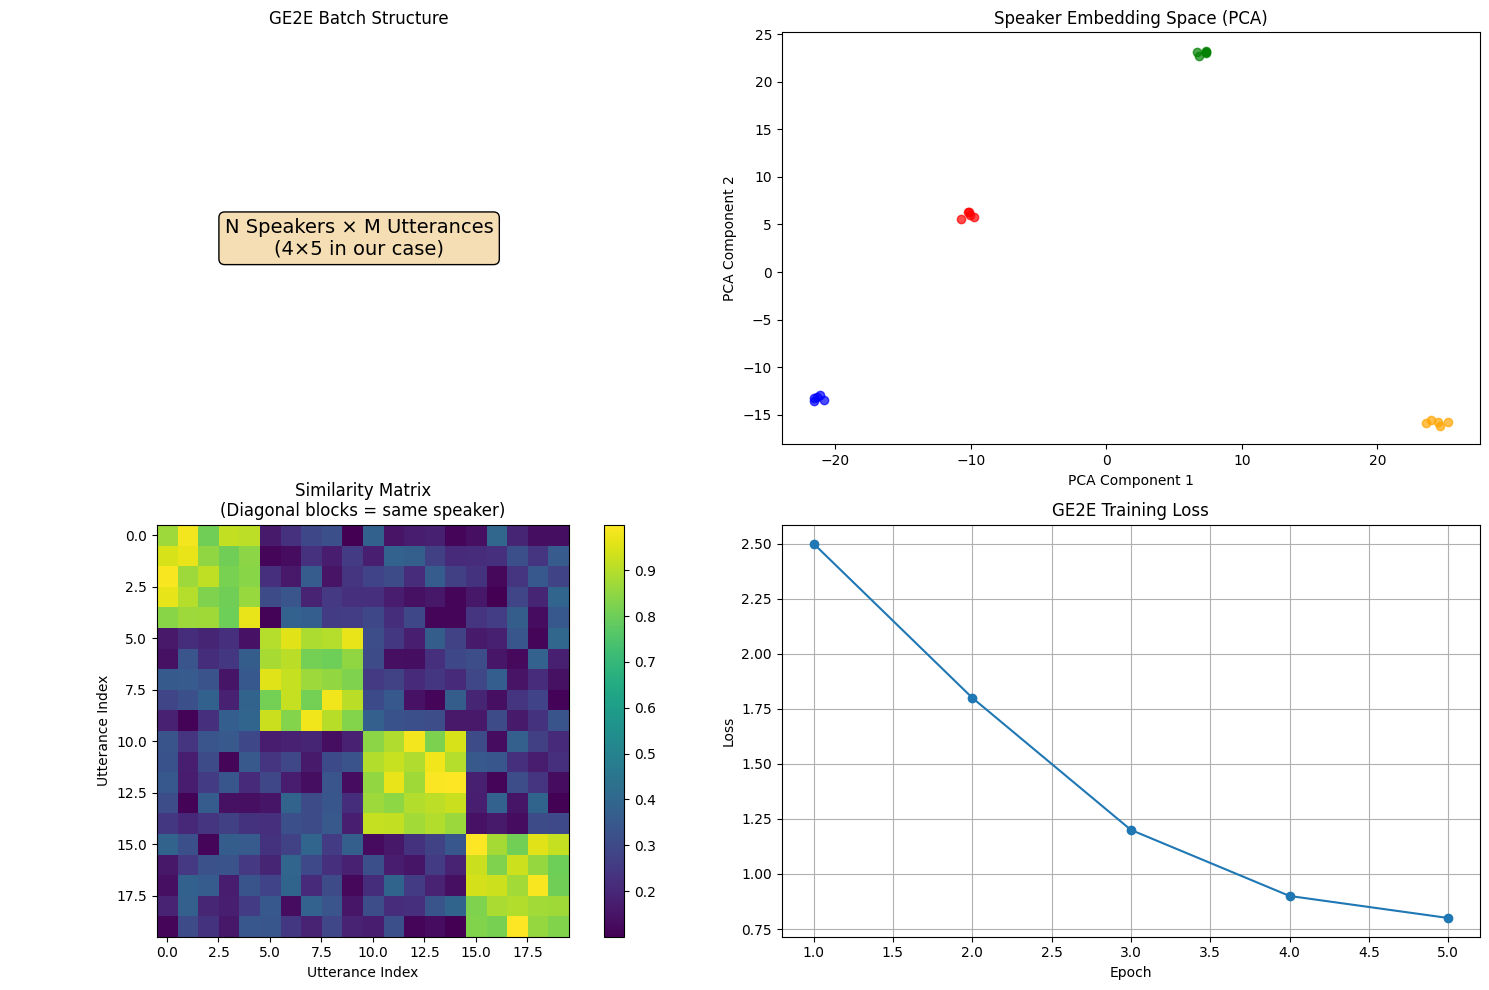

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def visualize_speaker_encoder():
    """Visualize speaker encoder training and results"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Show batch structure
    axes[0,0].text(0.5, 0.5, "N Speakers × M Utterances\n(4×5 in our case)", 
                   ha='center', va='center', fontsize=14, 
                   bbox=dict(boxstyle="round", fc="wheat"))
    axes[0,0].set_title("GE2E Batch Structure")
    axes[0,0].axis('off')

    # 2. Show embedding space concept
    np.random.seed(42)
    embeddings = []
    for i in range(4):  # 4 speakers
        center = np.random.randn(256) * 2
        for j in range(5):  # 5 utterances per speaker
            emb = center + np.random.randn(256) * 0.3
            embeddings.append((emb, i))

    pca = PCA(n_components=2)
    emb_2d = pca.fit_transform([e[0] for e in embeddings])
    colors = ['red', 'blue', 'green', 'orange']

    for emb_2d_point, (_, speaker_idx) in zip(emb_2d, embeddings):
        axes[0,1].scatter(emb_2d_point[0], emb_2d_point[1], color=colors[speaker_idx], alpha=0.7)

    axes[0,1].set_title("Speaker Embedding Space (PCA)")
    axes[0,1].set_xlabel("PCA Component 1")
    axes[0,1].set_ylabel("PCA Component 2")

    # 3. Show similarity matrix concept
    similarity = np.zeros((20, 20))
    for i in range(20):
        for j in range(20):
            speaker_i = i // 5
            speaker_j = j // 5
            if speaker_i == speaker_j:
                similarity[i, j] = 0.8 + np.random.rand() * 0.2
            else:
                similarity[i, j] = 0.1 + np.random.rand() * 0.3

    im = axes[1,0].imshow(similarity, cmap='viridis')
    axes[1,0].set_title("Similarity Matrix\n(Diagonal blocks = same speaker)")
    axes[1,0].set_xlabel("Utterance Index")
    axes[1,0].set_ylabel("Utterance Index")
    plt.colorbar(im, ax=axes[1,0])

    # 4. Show training progress placeholder
    axes[1,1].plot([1, 2, 3, 4, 5], [2.5, 1.8, 1.2, 0.9, 0.8], 'o-')
    axes[1,1].set_title("GE2E Training Loss")
    axes[1,1].set_xlabel("Epoch")
    axes[1,1].set_ylabel("Loss")
    axes[1,1].grid(True)

    plt.tight_layout()
    plt.show()

visualize_speaker_encoder()
